# SuperNEMO Analysis
## Vertical electron trajectories

*Summer Project – July 27th to Aug 5th, 2022*

*author: Casimir Fisch*

This Notebook contains all the functions and methods developed as part of the Summer Project.

In particular, it features:

- filtering methods to obtain valid electron tracks, comprising a 2D linear fit
- visualisation methods to display the tracks vertically, horizontally and in 3D
- methods to inspect the total PPT across the cells of the tracker
- methods to reconstruct the vertical trajectory of an electron from its recorded cathode times
- methods to estimate the overall uncertainty associated with the vertical reconstruction of electron positions in the cells
- methods to reconstruct the vertical position of hits with a missing cathode hit

In [1]:
'''IMPORTS'''

import numpy as np
import matplotlib.pyplot as plt
import ROOT
from scipy.optimize import curve_fit
import matplotlib.cm as cm
from matplotlib import colors
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pathlib import Path
import os
from itertools import compress
from matplotlib.patches import Circle
from scipy import odr
from collections import Counter

plt.style.use('seaborn-deep')
plt.rcParams['font.family'] = 'Open Sans'

Welcome to JupyROOT 6.24/06


### CHOOSE RUN NUMBER

local ROOT file must be in the 'ROOT files' directory

In [10]:
run_number = 732

# CONSTANTS
tdc2sec = 12.5e-9
c_tdc2sec = 6.25e-9
tracker_height = 3.
cell_radius = 0.022 * 100 # order of magnitude
cell_diameter = 2*cell_radius
cell_err = cell_radius

# from Betsy's work on anode stuff
a, b = [8.56128044e-07, -9.14129862e-01]   # r < 2.2
a2, b2 = [3.96575107e-07, -1.98864081e+00] # r > 2.2

# directories to which data / plots will be stored to

filedir = f'{run_number}/Files/'
plotsdir = f'{run_number}/Plots/'
tptdir = f'{run_number}/TPT/'
residdir = f'{run_number}/Residuals/'

if not os.path.exists(filedir): os.makedirs(filedir)
if not os.path.exists(plotsdir): os.makedirs(plotsdir)
if not os.path.exists(tptdir): os.makedirs(tptdir)
if not os.path.exists(residdir): os.makedirs(residdir)

level1_tracks_file = filedir+'tracks_firstlevel_max20_min8_minpos6.txt'
level2_tracks_file = filedir+'tracks_secondlevel_cutoff_0.05.txt'
level2_2D_tracks_file = filedir+'tracks_secondlevel_2D_cutoff_0.025.txt'
level1_missingcath_file = filedir+'tracks_firstlevel_missingcath_max20_min8_minpos6.txt'
level2_missingcath_file = filedir+'tracks_secondlevel_missingcath_cutoff_0.05.txt'
level2_withradii_tracks_file = filedir+'tracks_secondlevel_withradii_cutoff_0.05.txt'
onerow_tracks_file = filedir+'tracks_onerow.txt'
onerow_missingcath_tracks_file = filedir+'tracks_onerow_missingcath.txt'
mean_tpts_file = filedir+'mean_tpts.txt'
mean_tpts_goodtracks_file = filedir+'mean_tpts_goodtracks.txt'

# ACCESS THE DATA USING THE ROOT TTREE
input_root_file = f'ROOT files/snemo_run-{run_number}_red.root'
file = ROOT.TFile(f'{input_root_file}', 'READ')
tree = file.RED

method necessary for the visual plotting methods below

In [11]:
def find_minmax_row():

    tree.GetEntry(0)
    rows = list(tree.tracker_cell_row_id)
    min_row, max_row = min(rows), max(rows)

    for event in tree:

        # layers = list(event.tracker_cell_layer_id) 
        rows = list(event.tracker_cell_row_id)
        # sides = list(event.tracker_cell_side_id)

        for r in rows:
            if r < min_row: min_row = r
            elif r > max_row: max_row = r

    print(f'min and max rows: {min_row} - {max_row}')
    return min_row, max_row

n_events = tree.GetEntries()
print(f'Total number of events: {n_events}')

min_row, max_row = find_minmax_row()

Total number of events: 61651
min and max rows: 0 - 37


# Filtering and plotting

To use the data, run filter level 1 and filter level 2 from the cell below successively. 

- **Level 1** filters tracks to ensure they have hits between a maximum and minimum value (20 and 8) 
and feature a mimimum of 6 'good hits' (with all cathode and anode times positive). It also ensures that the track features hits in the layers close to the source foil and the calorimeter walls.

- **Level 2** applies additional filtering to the tracks selected by level 1 by applying a cut-off  
for the residuals of a vertical 2D linear fit (and using the radial data from the anode). This ensures that the tracks passing the filter  
correspond to valid electron tracks, by dismissing events featuring outlier hits or complex topologies (eg more than one track).

In [12]:
def filter_level1(max_hits=20, min_hits=8, min_positive=6):

    # perform first-level filtering to the events in the ntuple file
    # and save the filtered tracks to a file, writing a track as [event_number side]

    filename = filedir + f'tracks_firstlevel_max{max_hits}_min{min_hits}_minpos{min_positive}.txt'
    f = open(filename, 'w')

    counter = 0

    for event in tree:

        event_number = event.event_id

        layers = list(event.tracker_cell_layer_id)
        sides = list(event.tracker_cell_side_id)

        hits_fr, hits_it = 0, 0
        good_hits_fr, good_hits_it = 0, 0 # ensures the variables are referenced

        for i in range(len(layers)):
            if sides[i] == 1:
                hits_fr += 1
            else: 
                hits_it += 1

        r5 = list(event.tracker_bottom_cathode_R5_ticks)[::10]
        r6 = list(event.tracker_top_cathode_R6_ticks)[::10]
        r0 = list(event.tracker_anode_R0_ticks)[::10]
        calo_ticks = list(tree.calo_ticks)                                
        calo_ht = list(tree.calo_ht)
        calo_times = list(compress(calo_ticks, calo_ht))

        if len(calo_times) == 0: continue

        # added filter to ensure that the track must feature at least a hit in the 0, 1 AND 7, 8 layers
        # this makes sure that the tracks start at the source foil and finish at the calorimeter wall
        low_layer_fr, high_layer_fr = False, False
        low_layer_it, high_layer_it = False, False

        for i in range(len(r0)):
            an_timestamp = r0[i] * tdc2sec
            an_time = an_timestamp - calo_times[0]*c_tdc2sec
            bot_time, top_time = r5[i]*tdc2sec - an_timestamp, r6[i]*tdc2sec - an_timestamp

            if sides[i] == 1: # france

                if max_hits >= hits_fr >= min_hits:
                    if an_time > 0 and bot_time > 0 and top_time > 0:
                        good_hits_fr += 1
                        layer = layers[i]
                        if layer == 0 or layer == 1: low_layer_fr = True
                        elif layer == 7 or layer == 8: high_layer_fr = True

            else: # italy

                if max_hits >= hits_it >= min_hits:
                    if an_time > 0 and bot_time > 0 and top_time > 0:
                        good_hits_it += 1
                        layer = layers[i]
                        if layer == 0 or layer == 1: low_layer_it = True
                        elif layer == 7 or layer == 8: high_layer_it = True

        if good_hits_fr >= min_positive and low_layer_fr == True and high_layer_fr == True:
            
            f.write('{} {}\n'.format(event_number, 1))
            counter+=1
        
        if good_hits_it >= min_positive and low_layer_it == True and high_layer_it == True:

            f.write('{} {}\n'.format(event_number, 0))
            counter+=1

    f.close()
    print('\ntotal tracks (filter 1): ', counter)

def filter_level2(resid_cutoff=0.05, onerow=False, missingcath=False):

    # combine everything into a single method to filter tracks 
    # with the radial data and a 2D linear fit. 
    # incorporate the possibility to filter one-row tracks and 
    # to use the missing cathode reconstruction method.

    filename = level1_tracks_file
    data = np.loadtxt(filename, dtype = int)
    e_nums, sides = data[:,0], data[:,1]

    newfile = filedir + f'tracks_secondlevel_cutoff_{resid_cutoff}.txt'
    f = open(newfile, 'w')
    counter = 0

    if onerow: onerow_file = open(onerow_tracks_file, 'w')

    # run through the good tracks and introduce a filter that gets rid of instances where the error on the fit
    # is above a certain cutoff value (0.05 by inspection of tracks).

    for i in range(len(e_nums)):

        event_number, side = e_nums[i], sides[i]
        tree.GetEntry(event_number)
        cells, layers, rows, an, vert_pos = filter_track(event_number, side)
        residuals = get_residuals_2D(layers, rows, an, vert_pos)

        no_bad_resids = True
        for resid in residuals:
            if abs(resid) > resid_cutoff: 
                no_bad_resids = False
                break 

        if no_bad_resids == False: continue 

        if onerow: # from accepted tracks, find the ones that are contained in a single row

            count_samerow = 0
            for row in rows:
                if row == rows[0]: count_samerow += 1
            
            if count_samerow == len(rows): # all rows are the same
                counter += 1
                onerow_file.write(f'{event_number} {sides[i]}\n')

  
        f.write('{} {}\n'.format(event_number, side))
        counter+=1

    f.close()

    print('total tracks without cutoff:', len(e_nums))
    print('total tracks with cutoff   :', counter)

def filter_onerow_tracks():

    filename = level2_tracks_file #level2_withradii_tracks_file
    data = np.loadtxt(filename, dtype = int)
    e_nums, sides = data[:,0], data[:,1]
    counter = 0

    newfile = open(onerow_tracks_file, 'w')

    for i in range(len(e_nums)):

        event_number = e_nums[i]
        tree.GetEntry(event_number)

        cell_nums, layers, rows, an, vert_pos = filter_track(event_number, sides[i])
        count_samerow = 0

        for row in rows:
            if row == rows[0]: count_samerow += 1
        
        if count_samerow == len(rows): # all rows are the same
            counter += 1
            newfile.write(f'{event_number} {sides[i]}\n')

    newfile.close()
    print(f'{counter} one-row tracks')

# more stuff
def filter_onerow_missingcath(with_radii=True):

    if with_radii: filename = onerow_withradii_tracks_file
    else: filename = onerow_tracks_file
    data = np.loadtxt(filename, dtype = int)
    e_nums, sides = data[:,0], data[:,1]
    counter = 0

    newfile = open(onerow_missingcath_tracks_file, 'w')

    for i in range(len(e_nums)):

        event_number, side = e_nums[i], sides[i]
        tree.GetEntry(event_number)

        r0s = list(tree.tracker_anode_R0_ticks)[::10]
        r1s = list(tree.tracker_anode_R1_ticks)[::10]
        r2s = list(tree.tracker_anode_R2_ticks)[::10]
        r3s = list(tree.tracker_anode_R3_ticks)[::10]
        r4s = list(tree.tracker_anode_R4_ticks)[::10]
        r5s = list(tree.tracker_bottom_cathode_R5_ticks)[::10]
        r6s = list(tree.tracker_top_cathode_R6_ticks)[::10]
        s = list(tree.tracker_cell_side_id)
        calo_ticks = list(tree.calo_ticks)                                
        calo_ht = list(tree.calo_ht)
        calo_times = list(compress(calo_ticks, calo_ht))

        count_missing_cathodes = 0

        for j in range(len(r0s)):

            r0, r1, r2, r3, r4, r5, r6 = r0s[j], r1s[j], r2s[j], r3s[j], r4s[j], r5s[j], r6s[j]

            if s[j] == side:
            
                an_timestamp = r0*tdc2sec
                an_time = an_timestamp - calo_times[0]*c_tdc2sec
                bot_time = r5*tdc2sec - an_timestamp
                top_time = r6*tdc2sec - an_timestamp

                if an_time > 0 and ((r5 < 0 and top_time > 0) or (bot_time > 0 and r6 < 0)): # one missing cath
                    count_missing_cathodes += 1
                    if (0 < r1 < r3 < r2 < r4): print(event_number, side)
                    elif r2 == 0 and 0 < r1 < r3 < r4: print(event_number, side)
        
        if count_missing_cathodes > 0:
            counter += 1
            newfile.write(f'{event_number} {sides[i]}\n')

    newfile.close()
    print(f'{counter} one-row tracks with a missing cathode')

def tracks_passing_filters():

    f1 = open(level1_tracks_file, 'r')
    data = np.loadtxt(f1)
    lvl1_n_events = np.unique(data[:,0]).size
    f2 = open(level2_tracks_file, 'r')
    data = np.loadtxt(f2)
    lvl2_n_events = np.unique(data[:,0]).size
    f3 = open(level1_missingcath_file, 'r')
    data = np.loadtxt(f3)
    lvl1_mc_n_events = np.unique(data[:,0]).size
    f4 = open(level2_missingcath_file, 'r')
    data = np.loadtxt(f4)
    lvl2_mc_n_events = np.unique(data[:,0]).size
    f1.close(); f2.close(); f3.close(); f4.close()
    fraction1 = lvl1_n_events / n_events *100
    fraction2 = lvl2_n_events / n_events *100
    fraction3 = lvl1_mc_n_events / n_events *100
    fraction4 = lvl2_mc_n_events / n_events *100

    print(f'*** run {run_number} ***\n')
    print('{} total events\n{} events from level 1 ({:.2f} %)\n{} events from level 2 ({:.2f} %)'.format(n_events, lvl1_n_events, fraction1, lvl2_n_events, fraction2))
    print('\nmissing cathode events:\n{} events from level 1 ({:.2f} %)\n{} events from level 2 ({:.2f} %)'.format(lvl1_mc_n_events, fraction3, lvl2_mc_n_events, fraction4))

def write_residuals_to_file(dim=2):

    # create mega list of all residuals across all events
    # then write them to individual files for each cell
    # can be done for the 1D (dim = 1) or 2D (dim = 2) linear fit

    filename = level2_tracks_file

    data = np.loadtxt(filename, dtype=int)
    e_nums, sides = data[:,0], data[:,1]

    all_cell_nums = get_all_cell_nums()
    resid_mega_list = [[] for i in range(len(all_cell_nums))]

    for i in range(len(e_nums)):

        event_number, side = e_nums[i], sides[i]

        cell_nums, layers, rows, an_times, vert_pos = filter_track(event_number, side)
        if dim == 2: # 2D residuals
            residuals = get_residuals_2D(layers, rows, an_times, vert_pos)
        else: # 1D residuals
            residuals = get_residuals_1D(layers, an_times, vert_pos)

        for j in range(len(cell_nums)):

            ind = all_cell_nums.index(cell_nums[j])
            resid_mega_list[ind].append(residuals[j])

    # write the mega list to files
    # also write the standard deviation of the residuals of one cell to a separate file
    # this is the vertical error used in plotting

    newfile = filedir + 'vertical_errors.txt'
    f = open(newfile, 'w')

    for z in range(len(all_cell_nums)):

        cell_num = all_cell_nums[z]
        resid_list = resid_mega_list[z]

        if dim == 2: resid_file = residdir + f'residuals_2D_cell_{cell_num}.txt'
        else: resid_file = residdir + f'residuals_1D_cell_{cell_num}.txt'

        if len(resid_list) != 0:
            np.savetxt(resid_file, resid_list)

        if len(resid_list) == 0:
            f.write('{} nan\n'.format(cell_num))

        elif len(resid_list) == 1:
            # potential malfunctioning cells, the error is the only available residual
            f.write('{} {:.6f}\n'.format(cell_num, resid_list[0]))

        else:
            # if still malfunctioning but at least 2 residuals, stdev is a good enough approx
            resid_stdev = np.std(resid_list)
            f.write('{} {:.6f}\n'.format(cell_num, resid_stdev))

    f.close()

def filter_event(event_number):

    tree.GetEntry(event_number)

    layers = list(tree.tracker_cell_layer_id) 
    rows = list(tree.tracker_cell_row_id)
    sides = list(tree.tracker_cell_side_id)
    r5 = list(tree.tracker_bottom_cathode_R5_ticks)[::10]
    r6 = list(tree.tracker_top_cathode_R6_ticks)[::10]
    r0 = list(tree.tracker_anode_R0_ticks)[::10]
    calo_ticks = list(tree.calo_ticks)                                
    calo_ht = list(tree.calo_ht)
    calo_times = list(compress(calo_ticks, calo_ht))

    an_times, bot_times, top_times, l, r, s = [], [], [], [], [], []
    for i in range(len(r0)):
        an_timestamp = r0[i]*tdc2sec
        an_time = an_timestamp - calo_times[0]*c_tdc2sec
        bot_time = r5[i]*tdc2sec - an_timestamp
        top_time = r6[i]*tdc2sec - an_timestamp
        if bot_time > 0 and top_time > 0 and an_time > 0:
            bot_times.append(bot_time*1e6) # µs
            top_times.append(top_time*1e6) # µs
            an_times.append(an_time) # keep in seconds
            l.append(layers[i]); r.append(rows[i]); s.append(sides[i])
    
    cell_nums = LRS_to_num(l, r, s)

    return cell_nums, l, r, s, an_times, top_times, bot_times

def remove_outlier_hits(cells, layers, rows, an_times, vert_pos, cutoff=0.05, factor=4):

    dist_from_foil = []
    first_idx = np.argmin(layers)
    l0, r0 = layers[first_idx], rows[first_idx]
    for i in range(len(layers)):
        layer, row = layers[i], rows[i]
        dist_from_foil.append((layer - l0)**2 + (row - r0)**2)

    zpos_sorted = np.array(vert_pos)[np.argsort(dist_from_foil)] #  vertical positions sorted

    bad_vals = []

    for i in range(len(zpos_sorted)): # identify the outlier hits from their vertical position

        # more restrictive - impose cutoff AND compare to difference between the other neighbours

        curr_z = zpos_sorted[i]

        if i == 0: # first hit
            next_z, nextnext_z = zpos_sorted[i+1], zpos_sorted[i+2]
            dist1, dist2, dist3 = abs(curr_z - next_z), abs(curr_z - nextnext_z), abs(next_z - nextnext_z)
            if dist1 > cutoff and dist2 > cutoff and dist1 > factor * dist3: 
                # reject curr_z if the next two are close together (< cutoff) while it it far from its neighbour
                # the fractional condition is for the relatively flat trajectories with clear outliers but smaller differences
                bad_vals.append(curr_z)

        elif i == len(zpos_sorted)-1: # last hit
            prev_z, prevprev_z = zpos_sorted[i-1], zpos_sorted[i-2]
            dist1, dist2, dist3 = abs(curr_z - prev_z), abs(curr_z - prevprev_z), abs(prev_z - prevprev_z)
            if dist1 > cutoff and dist2 > cutoff and dist1 > factor * dist3: 
                # reject curr_z 
                bad_vals.append(curr_z)

        else:
            next_z, prev_z = zpos_sorted[i+1], zpos_sorted[i-1]
            dist1, dist2, dist3 = abs(curr_z - next_z), abs(curr_z - prev_z), abs(next_z - prev_z)
            if dist1 > cutoff and dist2 > cutoff and dist1 > factor * dist3:
                bad_vals.append(curr_z)  

    if len(bad_vals) != 0: 
        for bad_zpos in bad_vals:
            idx = vert_pos.index(bad_zpos)
            del cells[idx]; del layers[idx]; del rows[idx]; del vert_pos[idx]; del an_times[idx]

    return cells, layers, rows, an_times, vert_pos

def filter_track(event_number, side):

    n, l, r, s, an, top, bot = filter_event(event_number)
    cell_nums, layers, rows, an_times, vert_pos = [], [], [], [], []
    for i in range(len(n)):
        if s[i] == side:
            z_pos = z_position(top[i], bot[i])
            cell_nums.append(n[i]); layers.append(l[i]); rows.append(r[i]) 
            an_times.append(an[i]); vert_pos.append(z_pos)

    return cell_nums, layers, rows, an_times, vert_pos

def scan_track(event_number, side):

    side_str = 'france' if side == 1 else 'italy'
    cell_nums, layers, rows, an_times, vert_pos = filter_track(event_number, side)
    
    sorted_inds = np.argsort(layers)
    cells, l, r = np.array(cell_nums)[sorted_inds], np.array(layers)[sorted_inds], np.array(rows)[sorted_inds]
    an = np.array(an_times)[sorted_inds]
    vert_sorted = np.array(vert_pos)[sorted_inds]
    horz_sorted = layers_to_distances(l)
    vert_errors = vertical_errors(cells)
    horz_errors = get_radii(an)

    print('\n*** Event {0} ({1}) ***'.format(event_number, side_str))
    for i in range(len(l)):
        print('''cell {} / layer {} / row {} / vertical dist {:.3f} +/- {:.3f}'''.format(cells[i], l[i], r[i], vert_sorted[i], vert_errors[i]))

    plot_vertical_withradii(vert_sorted, horz_sorted, vert_errors, horz_errors, event_number, side)

def invertfunc(t, a, b):
    # A function that calculates distance from time
    power = (1/(1-b))
    return (t/a)**power

def get_radii(an_times):

    rs = []
    for an_time in an_times:
        if 0 < an_time <= 4e-6:
            r = invertfunc(an_time, a, b)
            rs.append(r)
        elif an_time > 4e-6:
            r = invertfunc(an_time, a2, b2)
            rs.append(r)
        else:
            rs.append(0)
    
    return rs # in cm

def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))

def plot_xy_event(event_number):

    n_rows, n_layers = (max_row - min_row + 1), 18
    grid = np.zeros((n_rows, n_layers))

    tree.GetEntry(event_number)

    layers = list(tree.tracker_cell_layer_id) 
    rows = list(tree.tracker_cell_row_id)
    sides = list(tree.tracker_cell_side_id)
    r5 = list(tree.tracker_bottom_cathode_R5_ticks)[::10]
    r6 = list(tree.tracker_top_cathode_R6_ticks)[::10]
    r0 = list(tree.tracker_anode_R0_ticks)[::10]
    calo_ticks = list(tree.calo_ticks)                                
    calo_ht = list(tree.calo_ht)
    calo_times = np.array(list(compress(calo_ticks, calo_ht)))
    
    layers = adjusted_layers(layers, sides)
    layers, rows, sides = np.array(layers), np.array(rows), np.array(sides)
    an_times = np.array(r0)*tdc2sec - calo_times[0]*c_tdc2sec
    bot_times = np.array(r5)*tdc2sec - an_times
    top_times = np.array(r6)*tdc2sec - an_times

    no_cathode_filter = (an_times > 0) * (top_times < 0) * (bot_times < 0)
    top_cathode_filter = (an_times > 0) * (top_times > 0) * (bot_times < 0)
    bot_cathode_filter = (an_times > 0) * (top_times < 0) * (bot_times > 0)
    both_cathodes_filter = (an_times > 0) * (top_times > 0) * (bot_times > 0)
    neg_anode_filter = (an_times < 0)

    colors, labels = [], []
    for i in range(len(an_times)):
        if no_cathode_filter[i] == True: colors.append('r'); labels.append('no cathodes')
        elif top_cathode_filter[i] == True: colors.append('orange'); labels.append('top cathode only')
        elif bot_cathode_filter[i] == True: colors.append('b'); labels.append('bottom cathode only')
        elif both_cathodes_filter[i] == True: colors.append('g'); labels.append('both cathodes')
        else: colors.append('k'); labels.append('no anode')

    fig, ax = plt.subplots(figsize=(10,12), tight_layout=True)
    ax.set_aspect(1)

    major_xticks = np.arange(min_row,max_row+1)
    minor_xticks = np.arange(min_row-.5,max_row+1.5)
    major_yticks = np.arange(-8.5,9.5)
    minor_yticks = np.arange(-9,10)
    layer_ticks = [8,7,6,5,4,3,2,1,0,0,1,2,3,4,5,6,7,8]

    rs = get_radii(an_times)
    u = ax.scatter(rows, layers, s=0)
    
    for i in range(len(rs)):
        if rs[i] > 0:
            p = Circle((rows[i], layers[i]), rs[i]/4.4, fill=True, color=colors[i], alpha=0.5, label=labels[i]) 
            ax.add_patch(p)
       
    ax.plot(np.arange(min_row-1,max_row+2), np.zeros_like(np.arange(min_row-1,max_row+2)), 'k', linewidth=2) # source foil line
    ax.set_xlim(min_row-.5,max_row+.5)
    ax.set_ylim(-9,9)
    ax.set_xticks(major_xticks)
    ax.set_yticks(major_yticks)
    ax.set_xticks(minor_xticks, minor = True)
    ax.set_yticks(minor_yticks, minor = True)
    ax.set_yticklabels(layer_ticks)
    ax.set_ylabel('layer')
    ax.set_xlabel('row')
    ax.grid(which='minor')
    ax.set_title(f'Event {event_number} - run {run_number}')
    
    ax.text(-.04, 0.75, 'ITALY', transform=ax.transAxes, fontsize='x-large', horizontalalignment='center', verticalalignment='center', rotation=90)
    ax.text(-.04, 0.25, 'FRANCE', transform=ax.transAxes, fontsize='x-large', horizontalalignment='center', verticalalignment='center', rotation=90)
    
    legend_without_duplicate_labels(ax)
    plt.show()

def plot_3D_event(event_number, scatter=True):

    fig = plt.figure(figsize=plt.figaspect(4)*3) #(10,8)
    ax = fig.add_subplot(projection='3d')

    xs = np.arange(min_row-.5, max_row+1.5, 0.1)
    zs = np.arange(0, tracker_height+0.1, 0.1)
    X, Z = np.meshgrid(xs, zs)
    Y = np.zeros_like(X)
    ax.plot_surface(X, Y, Z, alpha=0.3, color='k', linewidth=10)

    major_xticks = np.arange(min_row, max_row+1, 5)
    minor_xticks = np.arange(min_row-.5, max_row+1.5)
    major_yticks = np.arange(-8.5,9.5)
    minor_yticks = np.arange(-9,10)
    layer_ticks = [8,7,6,5,4,3,2,1,0,0,1,2,3,4,5,6,7,8]

    ax.set_xlim(min_row-.5, max_row+1.5)
    ax.set_ylim(-8.5,8.5)
    ax.set_xticks(major_xticks)
    ax.set_yticks(major_yticks)
    # ax.set_xticks(minor_xticks, minor = True)
    # ax.set_yticks(minor_yticks, minor = True)
    ax.set_yticklabels(layer_ticks)
    ax.xaxis.grid(which='minor')
    ax.yaxis.grid(which='minor')

    text_rowpos = (min_row+max_row)/2
    ax.text(text_rowpos, -4, 0.1*tracker_height, 'Italy',  fontsize='large', horizontalalignment='center', verticalalignment='center', fontfamily='serif')
    ax.text(text_rowpos, +4, 0.1*tracker_height, 'France', fontsize='large', horizontalalignment='center', verticalalignment='center', fontfamily='serif')

    ax.set_zlim(0, tracker_height)
    ax.set_xlabel('Row number')
    ax.set_ylabel('Layer number')
    ax.set_zlabel('Vertical distance')
    # title = f'3D plot of event {event_number}'

    _, l, r, s, an, top, bot = filter_event(event_number)
    vert_dist = vertical_dist(top, bot)
    l = adjusted_layers(l, s)

    if scatter == True:
        ax.scatter(r, l, vert_dist, color='r')
    else:
        ax.plot(r, l, vert_dist)

    ax.view_init(15,-8)
    ax.set_box_aspect(aspect = (3,1,1))
    # ax.set_title(title)
    fig.savefig('3D_2sides_event{}.png'.format(event_number))
    plt.show()

def adjusted_layers(l, s):

    adjusted_layers = []

    for i in range(len(l)):
        if s[i] == 0: # italy on top
            adjusted_layer =  l[i] + .5
            adjusted_layers.append(adjusted_layer)
        else:
            adjusted_layer = -l[i] - .5
            adjusted_layers.append(adjusted_layer)

    return adjusted_layers #np.array(adjusted_layers)

def num_to_LRS(cell_nums):

    layers, rows, sides = [], [], []

    for cell_num in cell_nums:
        sides.append(cell_num // (9 * 113))
        rows.append(cell_num % (9 * 113) // 9)
        layers.append(cell_num % (9 * 113) % 9)
    
    return layers, rows, sides

def LRS_to_num(layers, rows, sides):

    nums = []
    for i in range(len(layers)):
        nums.append(sides[i]*113*9 + rows[i]*9 + layers[i])
    return nums

def calc_cell_num(l, r, s):
    return s*113*9 + r*9 + l

def calc_LRS(cell_num):
    return cell_num % (9 * 113) % 9, cell_num % (9 * 113) // 9, cell_num // (9 * 113)

def vertical_dist(top_times, bot_times):

    bot_distances = []
    for i in range(len(top_times)):
        tpt = top_times[i] + bot_times[i]
        bot_distances.append(bot_times[i] / tpt * tracker_height)
    return bot_distances

def z_position(top_time, bot_time):
    # dtype accepted: np.ndarray or float
    return tracker_height * bot_time / (top_time + bot_time)

def vertical_errors(cells_list):

    data = np.loadtxt(filedir+'vertical_errors.txt', dtype=float)
    cell_nums, vert_errs = data[:,0].astype(int), data[:,1]

    errors = []

    for cell in cells_list:
        error_bar = vert_errs[cell_nums==cell][0] / 2
        errors.append(error_bar)
    
    return errors

def layers_to_distances(layers):

    horz_dists = []
    for i in range(len(layers)):
        horz_dists.append((layers[i] + .5) * cell_diameter)
    return horz_dists

def rows_to_distances(rows):

    tunnel_dists = []
    for i in range(len(rows)):
        tunnel_dists.append((rows[i]) * cell_diameter)
    return tunnel_dists

def plot_vertical(vert_dist, horz_dist, vert_errs, horz_errs, event_number, side, mc_idx=None):

    # if mc_idx (missing cathode index) is not None, then mark those hits with a different colour to stand out

    side_str = 'france' if side == 1 else 'italy'

    quad_model = odr.Model(linear_1D)
    data = odr.RealData(horz_dist, vert_dist, sx=horz_errs, sy=vert_errs)
    ODR = odr.ODR(data, quad_model, beta0=[1,1])
    out = ODR.run()
    popt = out.beta

    x_fit = np.arange(0,9.1,0.1)*cell_diameter
    fit = linear_1D(popt, x_fit)
    cell_boundaries = np.arange(0.5,8.5)*cell_diameter + cell_radius

    fig, ax = plt.subplots(tight_layout=True, figsize=(5,6))

    ax.errorbar(horz_dist, vert_dist, yerr=vert_errs, xerr=horz_errs, fmt='o', color='k')
    if mc_idx is not None:
        ax.errorbar(horz_dist[mc_idx], vert_dist[mc_idx], yerr=vert_errs[mc_idx], xerr=horz_errs[mc_idx], fmt='o', color='g')
    ax.plot(x_fit, fit, '-', color='r')
    ax.set_title('Run {} - Event {}, {}'.format(run_number, event_number, side_str.capitalize()))
    ax.set_xlabel('layer axis /cm') 
    ax.set_ylabel('z /m', rotation='horizontal')
    ax.yaxis.set_label_coords(-0.05,1.)
    ax.set_xlim(x_fit[0], x_fit[-1])

    for boundary in cell_boundaries:
        ax.axvline(boundary, color='k', linestyle='dashed', alpha=0.5, linewidth=1)

    plt.show()

def get_all_cell_nums():

    rows = np.arange(min_row,max_row+1)
    layers = np.arange(0,9)
    sides = np.array([0,1])

    all_cell_nums = []

    for side in sides:
        for layer in layers:
            for row in rows:
                all_cell_nums.append(side*113*9 + row*9 + layer)

    return all_cell_nums

def linear_1D(p, x):
    m, c = p
    return m*x + c

def linear_2D(p, x):
    a, b, c = p
    return a*x[0] + b*x[1] + c

def get_residuals_1D(layers, an, vert_dist):

    horz_dist = layers_to_distances(layers)
    horz_errors = get_radii(an)

    quad_model = odr.Model(linear_1D)
    data = odr.RealData(horz_dist, vert_dist, sx=horz_errors)
    ODR = odr.ODR(data, quad_model, beta0=[1,1])
    out = ODR.run()
    popt = out.beta
    resids = []
    for i in range(len(vert_dist)):
        resids.append(vert_dist[i] - linear_1D(popt, horz_dist[i]))
    return resids

def get_residuals_2D(layers, rows, an, vert_dist):

    horz_dist = layers_to_distances(layers)
    tunnel_dist = rows_to_distances(rows)
    horz_errors = get_radii(an)

    x = np.array([horz_dist, tunnel_dist])
    dx = np.array([horz_errors, horz_errors])
    z = vert_dist

    quad_model = odr.Model(linear_2D)
    data = odr.RealData(x, z, sx=dx)
    ODR = odr.ODR(data, quad_model, beta0=[1,1,1])
    out = ODR.run()
    popt = out.beta
    resids = []
    for i in range(len(vert_dist)):
        resids.append(vert_dist[i] - linear_2D(popt, x[:,i]))
    return resids

def plot2D_cell_numbers():

    all_cell_nums = np.array(get_all_cell_nums())
    grid_it = all_cell_nums[all_cell_nums // (9 * 113) == 0].reshape(9, (max_row-min_row+1))
    grid_fr = all_cell_nums[all_cell_nums // (9 * 113) == 1].reshape(9, (max_row-min_row+1))
    grid = np.zeros((9, (max_row-min_row+1)))

    fig, (ax1, ax2) = plt.subplots(2, figsize = (16,8))

    cmap = colors.ListedColormap(['mediumaquamarine','red'])
    bounds = [0,1]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    im1 = ax1.imshow(grid, cmap=cmap, norm=norm)
    im2 = ax2.imshow(grid, cmap=cmap, norm=norm)

    s = 0
    for l in range(9):
        for r in range((max_row-min_row+1)):
            cell_num = s*113*9 + r*9 + l
            ax1.text(r, l, f'{cell_num}', fontsize='smaller', horizontalalignment='center', verticalalignment='center')
    
    s = 1
    for l in range(9):
        for r in range((max_row-min_row+1)):
            cell_num = s*113*9 + r*9 + l
            ax2.text(r, l, f'{cell_num}', fontsize='smaller', horizontalalignment='center', verticalalignment='center')


    ax1.invert_yaxis()
    ax1.set_xticks(range(min_row, max_row+1, 5))
    ax2.set_xticks([])
    ax1.set_yticks(range(9))
    ax2.set_yticks(range(8,-1,-1))

    ax1.text(-.03, 1, 'ITALY', transform=ax1.transAxes, fontsize='x-large', horizontalalignment='center', verticalalignment='top', rotation=90)
    ax2.text(-.03, 0, 'FRANCE', transform=ax2.transAxes, fontsize='x-large', horizontalalignment='center', verticalalignment='bottom', rotation=90)

    for ax in [ax1,ax2]:

        ax.set_xticks(np.arange(min_row+0.5, max_row+0.5), minor=True)
        ax.set_yticks(np.arange(0.5,8.5), minor=True)

        # Gridlines based on minor ticks
        ax.grid(which='minor', color='k', linestyle='-', linewidth=1)

    fig.subplots_adjust(hspace=0.1)

    plt.show()

def all_filtering():

    # does all the necessary filtering for a given run
    filter_level1()
    filter_level2()
    write_residuals_to_file()
    filter_onerow_tracks()

In [13]:
all_filtering()


total tracks (filter 1):  16793
total tracks without cutoff: 16793
total tracks with cutoff   : 13908
818 one-row tracks


# Cathode plasma propagation time

Code to write the mean total propagation time for each cell to a file and to display the results as a 2D histogram

In [14]:
def write_mean_tpt_to_file():

    all_cell_nums = get_all_cell_nums()
    tpt_mega_list = [[] for i in range(len(all_cell_nums))]
    # mean_tdts = np.zeros(len(all_cell_nums))

    for event in tree:

        event_number = event.event_id

        layers = list(event.tracker_cell_layer_id) 
        rows = list(event.tracker_cell_row_id)
        sides = list(event.tracker_cell_side_id)
        cell_nums = LRS_to_num(layers, rows, sides)

        if len(layers) > 50: 
        # filter out certain events that have almost all of the cells triggered
            print(f'event {event_number} has {len(layers)} hits')
            continue

        r5 = list(event.tracker_bottom_cathode_R5_ticks)[::10]
        r6 = list(event.tracker_top_cathode_R6_ticks)[::10]
        r0 = list(event.tracker_anode_R0_ticks)[::10]

        for i in range(len(layers)):

            an_time = r0[i]*tdc2sec

            if an_time < 0 or (r5[i]*tdc2sec - an_time) < 0 or (r6[i]*tdc2sec - an_time) < 0:
                continue

            tpt = ((r5[i]+r6[i])*tdc2sec - 2*an_time)*1e6
            ind = all_cell_nums.index(cell_nums[i])
            tpt_mega_list[ind].append(tpt)

    f = open(mean_tpts_file, 'w')

    for j in range(len(all_cell_nums)):

        if len(tpt_mega_list[j]) != 0:
            mean_tpt = np.mean(tpt_mega_list[j])
            tpt_stdev = np.std(tpt_mega_list[j])
            f.write('{} {:.4f} {:.4f}\n'.format(all_cell_nums[j], mean_tpt, tpt_stdev))
            tpt_file = tptdir + f'tpt_cell_{all_cell_nums[j]}.txt'
            np.savetxt(tpt_file, tpt_mega_list[j])

        else:
            f.write('{} nan nan\n'.format(all_cell_nums[j]))
            print(all_cell_nums[j], 'empty!')

    f.close()

def get_bad_cells_tpt():

    # cells with no registered PPT across all cells for the whole run
    bad_cell_list = []

    all_cell_nums = np.array(get_all_cell_nums())
    for cell_num in all_cell_nums:
        tpt_file = tptdir + f'tpt_allevents_cell_{cell_num}.txt'
        if Path(tpt_file).exists() == False: 
            bad_cell_list.append(cell_num)
    return bad_cell_list

def hist_tpt_cell(cell, min_val=0, max_val=0):

    layer, row, side = calc_LRS(cell)
    side_str = 'France' if side==1 else 'Italy'

    tpt_file = tptdir + f'tpt_cell_{cell}.txt'

    if Path(tpt_file).exists(): 

        tpts = np.loadtxt(tpt_file)
        if min_val != 0 and max_val != 0:
            good_indices = (tpts > min_val) * (tpts < max_val)
            tpts = tpts[good_indices]
        
        mean_tpt, tpt_std = np.mean(tpts), np.std(tpts)
        print('\nCell Number: {}\nMean propagation time = {:.4f} / stdev = {:.4f}\n'.format(cell, mean_tpt, tpt_std))

        n_bins = 25
        fig, ax = plt.subplots(figsize=(5,6), tight_layout=True)
        ax.hist(tpts, bins=n_bins, histtype='stepfilled', color='purple', linewidth=1) #range=[-.05,.05]
        ax.set_xlabel('plasma propagation time /µs')
        ax.set_ylabel('count')
        ax.set_title(f'Total plasma propagation times for cell {cell} (row {row}, layer {layer}, {side_str}) - run {run_number}')
        ax.text(.8, .85, 'mean PPT\n{:.2f} µs'.format(tpts), transform=ax.transAxes, color='k', fontsize='x-large', horizontalalignment='center', verticalalignment='center')
        plt.show()

    else: print('no registered PPT for that cell!')

def check_malfunctioning_cell(cell_num):

    # checks if a given cell presents aby malfunction 
    # such as a broken anode / broken cathode / zero hits registered /...

    print(f'** Cell {cell_num} **')

    hits = 0
    neg_an_hits = 0
    neg_tc_hits = 0
    neg_bc_hits = 0

    for event in tree:

        layers = list(event.tracker_cell_layer_id) 
        rows = list(event.tracker_cell_row_id)
        sides = list(event.tracker_cell_side_id)
        cell_nums = LRS_to_num(layers, rows, sides)

        if cell_num not in cell_nums:
            continue

        hits += 1

        r5 = list(event.tracker_bottom_cathode_R5_ticks)[::10]
        r6 = list(event.tracker_top_cathode_R6_ticks)[::10]
        r0 = list(event.tracker_anode_R0_ticks)[::10]
        an_timestamp = r0[cell_nums.index(cell_num)]
        top_timestamp = r6[cell_nums.index(cell_num)]
        bot_timestamp = r5[cell_nums.index(cell_num)]

        if an_timestamp < 0: neg_an_hits += 1
        if top_timestamp < 0: neg_tc_hits += 1
        if bot_timestamp < 0: neg_bc_hits += 1


    print(f'{hits} hits, {neg_an_hits} neg an, {neg_tc_hits} neg tc, {neg_bc_hits} neg bc')
    if hits == 0:
        print('zero hits')
    else:
        if neg_an_hits / hits > 0.85: # above 85% are negative
            print(f'broken anode')
        if neg_tc_hits / hits > 0.85:
            print(f'broken top cathode')
        if neg_bc_hits / hits > 0.85:
            print(f'broken bot cathode')

def check_malfunctioning_cells(cell_list):

    broken_anodes, broken_top_caths, broken_bot_caths, zero_orone_hits = [], [], [], []

    # start with bad plasma propagation cells

    filename = mean_tpts_file
    data = np.loadtxt(filename)
    cells, mean_tpts = data[:,0].astype(int), data[:,1].astype(float)
    tpt_too_high = list(cells[mean_tpts > 60])

    hits_list = np.zeros_like(cell_list)
    neg_an_hits_list = np.zeros_like(cell_list) # negative anode
    neg_tc_hits_list = np.zeros_like(cell_list) # negative top cathode
    neg_bc_hits_list = np.zeros_like(cell_list) # negative bot cathode

    for event in tree:

        layers = list(event.tracker_cell_layer_id) 
        rows = list(event.tracker_cell_row_id)
        sides = list(event.tracker_cell_side_id)
        cell_nums = LRS_to_num(layers, rows, sides)
        r5 = list(event.tracker_bottom_cathode_R5_ticks)[::10]
        r6 = list(event.tracker_top_cathode_R6_ticks)[::10]
        r0 = list(event.tracker_anode_R0_ticks)[::10]

        for cell_num in cell_list:

            if cell_num in cell_nums:

                index = cell_list.index(cell_num)

                hits_list[index] += 1

        # anode_hits += 1; top_cath_hits += 1; bot_cath_hits += 1
        
                an_timestamp = r0[cell_nums.index(cell_num)]
                top_timestamp = r6[cell_nums.index(cell_num)]
                bot_timestamp = r5[cell_nums.index(cell_num)]

                if an_timestamp < 0: neg_an_hits_list[index] += 1
                if top_timestamp < 0: neg_tc_hits_list[index] += 1
                if bot_timestamp < 0: neg_bc_hits_list[index] += 1

    for i in range(len(cell_list)):

        cell = cell_list[i]
        hits = hits_list[i]
        neg_an_hits = neg_an_hits_list[i]
        neg_tc_hits = neg_tc_hits_list[i]
        neg_bc_hits = neg_bc_hits_list[i]

        print(f'Cell {cell}: {hits} hits, {neg_an_hits} neg an, {neg_tc_hits} neg tc, {neg_bc_hits} neg bc')
        if hits == 0 or hits == 1:
            zero_orone_hits.append(cell)
        else:
            if neg_an_hits / hits > 0.75: # above 90% are negative
                print(f'broken anode')
                broken_anodes.append(cell)
            if neg_tc_hits / hits > 0.75:
                print(f'broken top cathode')
                broken_top_caths.append(cell)
            if neg_bc_hits / hits > 0.75:
                print(f'broken bot cathode')
                broken_bot_caths.append(cell)

    return zero_orone_hits, broken_anodes, broken_top_caths, broken_bot_caths, tpt_too_high

def get_mean_tpts_fromfile(with_limit=False, limit=60):

    all_cell_nums = np.array(get_all_cell_nums())
    mean_tpts = []

    for cell_num in all_cell_nums:

        tpt_file = tptdir + f'tpt_cell_{cell_num}.txt'
        if Path(tpt_file).exists() == False: 
            mean_tpts.append(np.nan)
            continue
        tpts = np.loadtxt(tpt_file)

        mean_tpt = np.mean(tpts)

        if with_limit:
            if mean_tpt > limit: # remove extreme values
                mean_tpts.append(np.nan) 
                print('cell {}: mean tpt = {:.2f}'.format(cell_num, mean_tpt))

        else:
            mean_tpts.append(mean_tpt)

    return all_cell_nums, mean_tpts

def hist2d_tpts(malf_categ_cells=[], malf_categ_labels=[], with_limit=False, limit=60, vmin=None, vmax=None):

    all_cell_nums, mean_tpts = get_mean_tpts_fromfile(with_limit=with_limit, limit=limit)
    data_arr = np.array(mean_tpts)
    data_arr[all_cell_nums == 1295] = np.nan
    tpt_too_high = data_arr > limit
    tpt_too_high_cells = list(np.array(all_cell_nums)[tpt_too_high])
    data_arr[tpt_too_high] = np.nan
    malf_categ_cells.append(tpt_too_high_cells)
    malf_categ_labels.append(f'PPT > {limit}')
    markers = ['x', 'o', '^', 'v', 'x']
    colors = ['k', 'k', 'k', 'k', 'r']

    grid_it = data_arr[all_cell_nums // (9 * 113) == 0].reshape(9, (max_row-min_row+1))
    grid_fr = data_arr[all_cell_nums // (9 * 113) == 1].reshape(9, (max_row-min_row+1))

    if vmin is None and vmax is None:
        vmin, vmax = np.nanmin(data_arr), np.nanmax(data_arr) 

    fig, axes = plt.subplots(2, figsize = (12,5))

    ax1, ax2 = axes[0], axes[1]

    cmap=cm.get_cmap('plasma')

    im1 = ax1.imshow(grid_it, cmap = cmap, vmin=vmin, vmax=vmax) #norm=normalizer
    im2 = ax2.imshow(grid_fr, cmap = cmap, vmin=vmin, vmax=vmax) #norm=normalizer

    if len(malf_categ_cells) != 0:

        for i in range(len(malf_categ_cells)):
            cell_list = malf_categ_cells[i]
            cell_arr = np.array(cell_list)
            l, r, s = cell_arr % (9 * 113) % 9, cell_arr % (9 * 113) // 9, cell_arr // (9 * 113)
            italy = s == 0; france = s == 1
            ax1.scatter(r[italy], l[italy], label=malf_categ_labels[i], marker=markers[i], color=colors[i], alpha=0.75)
            ax2.scatter(r[france], l[france], label=malf_categ_labels[i], marker=markers[i], color=colors[i], alpha=0.75)

    ax1.invert_yaxis()
    ax1.set_xticks(range(min_row, max_row+1, 5))
    ax2.set_xticks([])
    ax1.set_yticks([])
    ax2.set_yticks([])

    ax1.text(-.02, 0, 'ITALY', transform=ax1.transAxes, fontsize='x-large', horizontalalignment='center', verticalalignment='bottom', rotation=90)
    ax2.text(-.02, 0, 'FRANCE', transform=ax2.transAxes, fontsize='x-large', horizontalalignment='center', verticalalignment='bottom', rotation=90)

    for ax in [ax1,ax2]:

        ax.set_xticks(np.arange(min_row+0.5, max_row+0.5), minor=True)
        ax.set_yticks(np.arange(0.5,8.5), minor=True)
        # Gridlines based on minor ticks
        ax.grid(which='minor', color='k', linestyle='-', linewidth=1)

    fig.subplots_adjust(top = 0.9, right=0.83, hspace=0.15)
    box1 = ax1.get_position(); box2 = ax2.get_position()
    c_bar_height = box1.y0 - box2.y0 + box1.height
    c_bar_ypos =  box2.y0
    cbar_ax = fig.add_axes([0.81, c_bar_ypos, 0.01, c_bar_height]) # 0.15 0.75
    fig.colorbar(im1, cax=cbar_ax)
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=5, fancybox = True, shadow=True)
    fig.suptitle(f'Mean plasma propagation time (µs) - run {run_number}', y=0.95)
    fig.savefig(plotsdir+f'hist2D_tpts_allevents_run{run_number}.png', dpi = 500)

    plt.show()

def plot_hist2d_tpts_with_malfunctioningcells():

    bad_cell_list = get_bad_cells_tpt()
    zero_orone_hits, broken_anodes, broken_top_caths, broken_bot_caths, tpt_too_high = check_malfunctioning_cells(bad_cell_list)
    # zero_orone_hits.append(1295)
    # print(zero_orone_hits)
    # vmin, vmax = 34.52263017200919, 67.15869496383729
    malf_cells = [zero_orone_hits, broken_anodes, broken_top_caths, broken_bot_caths]
    malf_labels = ['zero or one hit', 'broken anode', 'broken top cathode', 'broken bottom cathode']
    hist2d_tpts(malf_categ_cells=malf_cells, malf_categ_labels=malf_labels)

event 100 has 57 hits
event 135 has 52 hits
event 281 has 67 hits
event 519 has 55 hits
event 551 has 52 hits
event 562 has 73 hits
event 760 has 52 hits
event 800 has 52 hits
event 875 has 51 hits
event 1977 has 51 hits
event 3038 has 58 hits
event 4063 has 51 hits
event 6856 has 53 hits
event 7048 has 77 hits
event 8209 has 59 hits
event 8369 has 54 hits
event 8917 has 55 hits
event 10204 has 53 hits
event 11087 has 55 hits
event 11989 has 51 hits
event 12750 has 87 hits
event 12812 has 51 hits
event 13323 has 61 hits
event 13361 has 64 hits
event 14086 has 53 hits
event 14221 has 51 hits
event 14313 has 61 hits
event 14700 has 51 hits
event 15511 has 53 hits
event 18487 has 71 hits
event 18722 has 54 hits
event 20065 has 56 hits
event 20877 has 52 hits
event 20933 has 87 hits
event 21154 has 51 hits
event 23022 has 56 hits
event 23130 has 68 hits
event 24021 has 54 hits
event 24038 has 54 hits
event 24348 has 57 hits
event 24732 has 56 hits
event 26151 has 58 hits
event 26352 has 55

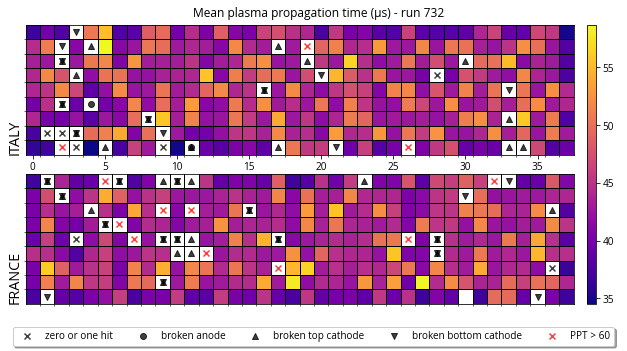

In [15]:
write_mean_tpt_to_file()
plot_hist2d_tpts_with_malfunctioningcells()

Code to compare runs 731 and 732

In [6]:
def get_mean_tpts_fromrun(run):

    all_cell_nums = np.array(get_all_cell_nums())
    mean_tpts = []

    for cell_num in all_cell_nums:

        tpt_file = f'{run}/TPT/tpt_allevents_cell_{cell_num}.txt'
        if Path(tpt_file).exists() == False: 
            mean_tpts.append(np.nan)
            continue
        mean_tpt = np.mean(np.loadtxt(tpt_file))
        mean_tpts.append(mean_tpt)

    return all_cell_nums, mean_tpts

def plot_hist2d_tpt_run(run, data_arr, vmin, vmax):

    all_cell_nums = np.array(get_all_cell_nums())
    grid_it = data_arr[all_cell_nums // (9 * 113) == 0].reshape(9, (max_row-min_row+1))
    grid_fr = data_arr[all_cell_nums // (9 * 113) == 1].reshape(9, (max_row-min_row+1))

    fig, axes = plt.subplots(2, figsize = (12,5))
    ax1, ax2 = axes[0], axes[1]

    cmap=cm.get_cmap('plasma')
    im1 = ax1.imshow(grid_it, cmap = cmap, vmin=vmin, vmax=vmax)
    im2 = ax2.imshow(grid_fr, cmap = cmap, vmin=vmin, vmax=vmax) 

    ax1.invert_yaxis()
    ax1.set_xticks(range(min_row, max_row+1, 5))
    ax2.set_xticks([])
    ax1.set_yticks([])
    ax2.set_yticks([])
    ax1.text(-.02, 0, 'ITALY', transform=ax1.transAxes, fontsize='x-large', horizontalalignment='center', verticalalignment='bottom', rotation=90)
    ax2.text(-.02, 0, 'FRANCE', transform=ax2.transAxes, fontsize='x-large', horizontalalignment='center', verticalalignment='bottom', rotation=90)

    for ax in [ax1,ax2]:

        ax.set_xticks(np.arange(min_row+0.5, max_row+0.5), minor=True)
        ax.set_yticks(np.arange(0.5,8.5), minor=True)
        ax.grid(which='minor', color='k', linestyle='-', linewidth=1)

    fig.subplots_adjust(top = 0.9, right=0.83, hspace=0.15)
    
    box1 = ax1.get_position(); box2 = ax2.get_position()
    c_bar_height = box1.y0 - box2.y0 + box1.height
    c_bar_ypos =  box2.y0
    cbar_ax = fig.add_axes([0.81, c_bar_ypos, 0.01, c_bar_height])
    fig.colorbar(im1, cax=cbar_ax)
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=5, fancybox = True, shadow=True)
    fig.suptitle(f'Mean plasma propagation time (µs) - run {run}', y=0.95)
    fig.savefig(f'/Users/casimirfisch/Desktop/Uni/Summer Project/Runs/TPT comparison/hist2D_tpts_run{run}.png', dpi = 500)

    plt.show()

def hist2d_compareruns(run1=731, run2=732, limit=70):

    all_cell_nums, mean_tpts_run1 = get_mean_tpts_fromrun(run1)
    _, mean_tpts_run2 = get_mean_tpts_fromrun(run2)
    data_arr1, data_arr2 = np.array(mean_tpts_run1), np.array(mean_tpts_run2)

    data_arr_list = [data_arr1, data_arr2]

    for i in range(2):

        data_arr = data_arr_list[i]
        data_arr[all_cell_nums == 1295] = np.nan
        tpt_too_high = data_arr > limit
        data_arr[tpt_too_high] = np.nan

    vmin1, vmax1 = np.nanmin(data_arr1), np.nanmax(data_arr1) 
    vmin2, vmax2 = np.nanmin(data_arr2), np.nanmax(data_arr2)
    vmin, vmax = min(vmin1, vmin2), max(vmax1, vmax2)
    print(vmin, vmax)

    plot_hist2d_tpt_run(run1, data_arr1, vmin=vmin, vmax=vmax)
    plot_hist2d_tpt_run(run2, data_arr2, vmin=vmin, vmax=vmax)

    # comparison plot

    new_arr = data_arr2 - data_arr1
    grid_it = new_arr[all_cell_nums // (9 * 113) == 0].reshape(9, (max_row-min_row+1))
    grid_fr = new_arr[all_cell_nums // (9 * 113) == 1].reshape(9, (max_row-min_row+1))
    vmin, vmax = np.nanmin(new_arr), np.nanmax(new_arr)

    fig, axes = plt.subplots(2, figsize = (12,5))

    ax1, ax2 = axes[0], axes[1]

    cmap=cm.get_cmap('jet')

    im1 = ax1.imshow(grid_it, cmap = cmap, vmin=vmin, vmax=vmax)
    im2 = ax2.imshow(grid_fr, cmap = cmap, vmin=vmin, vmax=vmax) 

    ax1.invert_yaxis()
    ax1.set_xticks(range(min_row, max_row+1, 5))
    ax2.set_xticks([])
    ax1.set_yticks([])
    ax2.set_yticks([])

    ax1.text(-.02, 0, 'ITALY', transform=ax1.transAxes, fontsize='x-large', horizontalalignment='center', verticalalignment='bottom', rotation=90)
    ax2.text(-.02, 0, 'FRANCE', transform=ax2.transAxes, fontsize='x-large', horizontalalignment='center', verticalalignment='bottom', rotation=90)

    for ax in [ax1,ax2]:

        ax.set_xticks(np.arange(min_row+0.5, max_row+0.5), minor=True)
        ax.set_yticks(np.arange(0.5,8.5), minor=True)
        ax.grid(which='minor', color='k', linestyle='-', linewidth=1)

    fig.subplots_adjust(top = 0.9, right=0.83, hspace=0.15)
    box1 = ax1.get_position(); box2 = ax2.get_position()
    c_bar_height = box1.y0 - box2.y0 + box1.height
    c_bar_ypos =  box2.y0
    cbar_ax = fig.add_axes([0.81, c_bar_ypos, 0.01, c_bar_height])
    fig.colorbar(im1, cax=cbar_ax)
    # handles, labels = ax.get_legend_handles_labels()
    # fig.legend(handles, labels, loc='lower center', ncol=5, fancybox = True, shadow=True)

    fig.suptitle(f'Difference in mean plasma propagation time (µs) - runs {run1} and {run2}', y=0.95)

    fig.savefig(f'/Users/casimirfisch/Desktop/Uni/Summer Project/Runs/TPT comparison/hist2D_tptsdiff_runs{run1}.{run2}.png', dpi = 500)

    plt.show()

# hist2d_compareruns()

# Hits in the tracker chambers

Looks at the total hits registered during the run, to identify the participation of cells to all events.

useful for identifying malfunctioning cells (disconnected, 'hot', or else)

In [7]:
def write_hits_cells_tofile(param='all', with_limit=False):

    filename = filedir+f'hits_cells_{param}.txt'
    if with_limit: filename = filedir+f'hits_cells_{param}_max50.txt'
    f = open(filename, 'w')

    all_cell_nums = np.array(get_all_cell_nums())
    hits_counts = np.zeros_like(all_cell_nums)

    if param == 'all':

        for event in tree:

            layers = list(event.tracker_cell_layer_id) 
            rows = list(event.tracker_cell_row_id)
            sides = list(event.tracker_cell_side_id)
            cell_nums = LRS_to_num(layers, rows, sides)

            if with_limit: 
                if len(cell_nums) > 50: continue

            for cell in cell_nums:
                hits_counts[all_cell_nums==cell] += 1

        for i in range(len(all_cell_nums)):
            f.write('{} {}\n'.format(all_cell_nums[i], hits_counts[i]))

    f.close()

def hist2D_hits(param='all', with_limit=False):

    filename = filedir+f'hits_cells_{param}.txt'
    if with_limit: filename = filedir+f'hits_cells_{param}_max50.txt'
    data = np.loadtxt(filename, dtype=float)
    cells, counts = data[:,0], data[:,1]
    fractions = counts / n_events
    fractions[fractions==0] = np.nan

    layer_ticks = [8,7,6,5,4,3,2,1,0,0,1,2,3,4,5,6,7,8]

    rows = np.arange(min_row,max_row+1)
    layers = np.arange(-8.5,9.5)
    Z_ = fractions.reshape(18, (max_row-min_row+1))
    Z = np.empty_like(Z_)
    Z[:9,:] = np.flipud(Z_[:9,:])
    Z[9:,:] = Z_[9:,:]

    fig, ax = plt.subplots(figsize=(10,6), tight_layout=True)
    title = f'Fraction of cell participation to all hits - run {run_number}'

    c = ax.pcolormesh(rows, layers, Z, edgecolors='k', linewidths=1, cmap='viridis')
    ax.plot(np.arange(min_row-.5,max_row+1.5), np.zeros_like(np.arange(min_row-.5,max_row+1.5)), 'k', linewidth=4) # source foil line
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=0.1)
    cbar = fig.colorbar(c, cax=cax)
    ax.set_title(title, fontsize='large')
    ax.set_xlabel('rows')
    ax.set_ylabel('layers')
    ax.set_yticks(layers, layer_ticks)
    ax.set_xticks(rows, rows)
    ax.text(-.04, 0.75, 'FRANCE', transform=ax.transAxes, fontsize='x-large', horizontalalignment='center', verticalalignment='center', rotation=90)
    ax.text(-.04, 0.25, 'ITALY', transform=ax.transAxes, fontsize='x-large', horizontalalignment='center', verticalalignment='center', rotation=90)
    ax.set_aspect(1)

    if with_limit:
        fig.savefig(plotsdir+f'hist2d_hits_{param}_max50.png')
    else:
        fig.savefig(plotsdir+f'hist2d_hits_{param}.png')

    plt.show()

# Residuals analysis

Looking at the residuals (across all cells) from a linear fit performed to the vertical trajectory of electrons

In [20]:
def hist_resids_cell_fromfile(cell_num):

    layer, row, side = cell_num % (9 * 113) % 9, cell_num % (9 * 113) // 9, cell_num // (9 * 113)
    side_str = 'France' if side==1 else 'Italy'

    resid_file = residdir + f'residuals_cell_{cell_num}.txt'
    resids = np.loadtxt(resid_file)*100 #cm

    mean_resid, resid_std = np.mean(resids), np.std(resids)
    print('\nCell Number: {}\nMean residual error = {:.4f} / stdev = {:.4f}\n'.format(cell_num, mean_resid, resid_std))

    fig = plt.figure(figsize=(5,6), tight_layout=True) # 
    plt.hist(resids, bins=25, color='indigo', histtype='step') # range=[-30,30]
    plt.axvline(5, color='k', linestyle='dashed', linewidth=1)
    plt.axvline(-5, color='k', linestyle='dashed', linewidth=1)
    plt.xlabel('vertical residuals /cm')
    plt.ylabel('counts')
    plt.xlim(-5,5)
    plt.title('Cell {} (row {}, layer {}, {})'.format(cell_num, row, layer, side_str))
    plt.text(3, 25, r'$\sigma = {:.2f} cm$'.format(resid_std), color='k', fontsize='x-large', horizontalalignment='center', verticalalignment='center')
    plt.show()

def hist2D_cells_resids(bad_cells_list, min_resids=50):

    all_cell_nums = np.array(get_all_cell_nums())
    l, r, s = num_to_LRS(all_cell_nums)
    l = adjusted_layers(l, s)
    stdev_resids, mean_resids, sigmas = [], [], []
    number_of_resids = []
    low_count_cells = []
    number_lowcount_cells = 0

    badtpt_l, badtpt_r, badtpt_s = num_to_LRS(bad_cells_list)
    badtpt_l = adjusted_layers(badtpt_l, badtpt_s)

    for cell_num in all_cell_nums:

        resid_file = residdir + f'residuals_2D_cell_{cell_num}.txt'

        if Path(resid_file).exists() == False:
            stdev_resids.append(np.nan); mean_resids.append(np.nan); sigmas.append(np.nan)
            continue

        if cell_num in [291]: # if very high/low value, can remove cell for visibility
            stdev_resids.append(np.nan); mean_resids.append(np.nan); sigmas.append(np.nan)
            continue

        residuals = np.loadtxt(resid_file)

        if residuals.size > min_resids: 

            stdev_resids.append(np.std(residuals)); mean_resids.append(np.mean(np.abs(residuals))); sigmas.append(get_sigma(residuals))
            number_of_resids.append(residuals.size)

        else: 
            stdev_resids.append(np.nan); mean_resids.append(np.nan); sigmas.append(np.nan)
            number_lowcount_cells += 1
            low_count_cells.append(cell_num)
    
    stdev_resids, mean_resids, sigmas = np.array(stdev_resids)*100, np.array(mean_resids)*100, np.array(sigmas)*100 #cm
    bad_indices = np.isnan(stdev_resids) 
    good_indices = ~bad_indices  # remove the nan values
    overall_stdev = np.mean(stdev_resids[good_indices])
    overall_mean = np.mean(mean_resids[good_indices])

    lowcount_l, lowcount_r, lowcount_s = num_to_LRS(low_count_cells)
    lowcount_l = adjusted_layers(lowcount_l, lowcount_s)

    print('Mean residual error for a cell: {:.4f}'.format(overall_mean))
    print('Mean residual stdev for a cell: {:.4f}'.format(overall_stdev))

    print('Average number of resids for good cells =', np.mean(number_of_resids))
    print(f'Number of cells with a count below {min_resids} =', number_lowcount_cells)

    layer_ticks = [8,7,6,5,4,3,2,1,0,0,1,2,3,4,5,6,7,8]

    rows = np.arange(min_row,max_row+1)
    layers = np.arange(-8.5,9.5)  
    Z_ = sigmas.reshape(18, (max_row-min_row+1))
    Z = np.empty_like(Z_)
    Z[:9,:] = np.flipud(Z_[:9,:])
    Z[9:,:] = Z_[9:,:]
    Z = np.flipud(Z)

    fig, ax = plt.subplots(figsize=(10,6), tight_layout=True)

    c = ax.pcolormesh(rows, layers, Z, edgecolors='k', linewidths=1)
    ax.plot(np.arange(min_row-.5,max_row+1.5), np.zeros_like(np.arange(min_row-.5,max_row+1.5)), 'k', linewidth=4) # source foil line
    ax.scatter(badtpt_r, badtpt_l, marker = 'x', color = 'k', label = 'bad tpt cells')
    ax.scatter(lowcount_r, lowcount_l, marker = 'o', color = 'r', label = 'low count cells')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=0.1)
    cbar = fig.colorbar(c, cax=cax)
    ax.set_xlabel('rows')
    ax.set_ylabel('layers')
    ax.set_yticks(layers, layer_ticks)
    ax.set_xticks(rows, rows)
    ax.text(-.04, 0.75, 'FRANCE', transform=ax.transAxes, fontsize='x-large', horizontalalignment='center', verticalalignment='center', rotation=90)
    ax.text(-.04, 0.25, 'ITALY', transform=ax.transAxes, fontsize='x-large', horizontalalignment='center', verticalalignment='center', rotation=90)
    ax.set_aspect(1)

    ax.set_title(f'Uncertainty on vertical track reconstruction for each cell (cm) - run {run_number}')

    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1,
                    box.width, box.height * 0.9])

    # Put a legend below current axis
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=4)
    fig.savefig(plotsdir+f'hist2d_resids_run{run_number}.png')
    plt.show()

def gaussian(x, A, mu, sigma):
    return A * np.exp(-1/2*((x-mu)/sigma)**2)

def hist_residual_error_forallcells(with_missing_cathode=False):

    all_cell_nums = get_all_cell_nums()
    all_resids = []

    for cell_num in all_cell_nums:

        if with_missing_cathode: resid_file = residdir + f'residuals_missingcath_2D_cell_{cell_num}.txt'
        else: resid_file = residdir + f'residuals_2D_cell_{cell_num}.txt'

        if Path(resid_file).exists() == False: continue
        resids = np.loadtxt(resid_file)
        if resids.size == 1: continue
        for resid in resids:
            all_resids.append(resid)

    all_resids = np.array(all_resids)*100 #cm
    mean_resid, resid_std = np.mean(all_resids), np.std(all_resids)
    n_bins, hist_range = 50, [-5,5]
    hist, bin_edges = np.histogram(all_resids, bins=n_bins, range=hist_range)
    bincenters = np.mean(np.vstack([bin_edges[0:-1],bin_edges[1:]]), axis=0)
    popt, pcov = curve_fit(gaussian, xdata=bincenters, ydata=hist, p0=[1000,0,10])
    sigma = np.abs(popt[2])
    print('\nsigma = {:.4f} cm\nstandard deviation = {:.4f} cm\n'.format(sigma, resid_std))

    fig, ax = plt.subplots(figsize=(5,6), tight_layout=True)
    ax.hist(all_resids, bins=n_bins, histtype='step', range=hist_range, color='k', linewidth=1) #range=[-.05,.05]
    # plt.axvline(mean_resid, color='k', linestyle='dashed', linewidth=1)
    x = np.linspace(hist_range[0], hist_range[-1], 500) #np.min(all_resids), np.max(all_resids)
    # plt.plot(x, gaussian(x, *popt), 'r--')
    ax.set_xlabel('vertical residuals /cm')
    ax.set_ylabel('counts')
    ax.set_title(f'Residual error across all cells - run {run_number}')

    ax.text(.8, .85, r'$\sigma = {:.2f} cm$'.format(sigma), transform=ax.transAxes, color='r', fontsize='x-large', horizontalalignment='center', verticalalignment='center')

    if with_missing_cathode: savedir = plotsdir+'resid_error_all_cells_missingcath.png'
    else: savedir = plotsdir+'resid_error_all_cells.png'
    fig.savefig(savedir)

    plt.show()

def hist_residual_error_onerow():

    all_cell_nums = get_all_cell_nums()
    all_resids = []

    for cell_num in all_cell_nums:

        resid_file = residdir + f'residuals_onerow_cell_{cell_num}.txt'

        if Path(resid_file).exists() == False: continue
        resids = np.loadtxt(resid_file)
        if resids.size == 1: continue
        for resid in resids:
            all_resids.append(resid)

    all_resids = np.array(all_resids)*100 #cm
    mean_resid, resid_std = np.mean(all_resids), np.std(all_resids)
    n_bins, hist_range = 50, [-5,5]
    hist, bin_edges = np.histogram(all_resids, bins=n_bins, range=hist_range)
    bincenters = np.mean(np.vstack([bin_edges[0:-1],bin_edges[1:]]), axis=0)
    popt, pcov = curve_fit(gaussian, xdata=bincenters, ydata=hist, p0=[1000,0,10])
    sigma = np.abs(popt[2])
    print('\nsigma = {:.4f} cm\nstandard deviation = {:.4f} cm\n'.format(sigma, resid_std))

    fig = plt.figure(figsize=(5,6), tight_layout=True)
    plt.hist(all_resids, bins=n_bins, histtype='step', range=hist_range, color='k', linewidth=1) #range=[-.05,.05]
    # plt.axvline(mean_resid, color='k', linestyle='dashed', linewidth=1)
    x = np.linspace(hist_range[0], hist_range[-1], 500) #np.min(all_resids), np.max(all_resids)
    plt.plot(x, gaussian(x, *popt), 'r--')

    plt.text(3.5, 700, r'$\sigma = {:.2f} cm$'.format(sigma), color='r', fontsize='x-large', horizontalalignment='center', verticalalignment='center')

    plt.xlabel('vertical residuals /cm')
    plt.ylabel('counts')
    plt.title(f'Residual error across all cells - run {run_number}')

    fig.savefig(plotsdir+'resid_error_all_cells_onerow.png')

    plt.show()

def get_sigma(residuals, plot_or_not=False, param='good tracks'):

    n_bins = 30
    hist, bin_edges = np.histogram(residuals, bins=n_bins)
    bincenters = np.mean(np.vstack([bin_edges[0:-1],bin_edges[1:]]), axis=0)
    popt, pcov = curve_fit(gaussian, xdata=bincenters, ydata=hist, p0=[1.3,3e-4,1.2e-2])
    sigma = np.abs(popt[2])

    if plot_or_not == True:
        fig = plt.figure(figsize=(5,6), tight_layout=True)
        plt.hist(residuals, bins=n_bins, color='k', histtype='step')
        x = np.linspace(residuals.min(), residuals.max(), 100)
        plt.plot(x, gaussian(x, *popt), 'r--')
        plt.xlabel('vertical residuals /m')
        plt.ylabel('counts')
        plt.show()
        # fig.savefig(plotsdir+f'hist_gaussian_resids_cell{cell_num}.png')

    # print('Cell {}, sigma = {:.4f} cm'.format(cell_num, sigma*100))
    return sigma

def tracks_with_cell(cell_num):

    side = cell_num // (9 * 113)

    data = np.loadtxt(level2_tracks_file, dtype=int)
    e_nums, sides = data[:,0], data[:,1]

    for i in range(len(e_nums)):

        if sides[i] != side: continue

        cell_nums, layers, rows, top_times, bot_times = filter_track(e_nums[i], side)

        if cell_num in cell_nums:
            print(e_nums[i], sides[i])

Mean residual error for a cell: 0.9199
Mean residual stdev for a cell: 1.2148
Average number of resids for good cells = 198.82828282828282
Number of cells with a count below 50 = 30


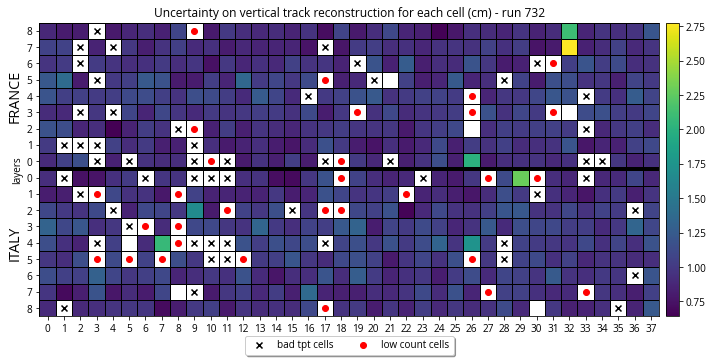

In [21]:
hist2D_cells_resids(bad_cells_list=get_bad_cells_tpt())

## Missing cathode timestamp - vertical reconstruction

In [22]:
def calc_missing_cath_fromTPT(cell_num, cath_time):

    filename = mean_tpts_file
    data = np.loadtxt(filename, dtype=float)
    cells, mean_tpts = data[:,0].astype(int), data[:,1]

    mean_tpt = mean_tpts[cells == cell_num][0]

    return mean_tpt - cath_time*1e6
    
def filter_lvl1_missingcath(max_hits=20, min_hits=8, min_positive=6):

    # perform first-level filtering to the events in the ntuple file
    # and save the filtered tracks to a file, writing a track as [event_number side]

    filename = filedir + f'tracks_firstlevel_missingcath_max{max_hits}_min{min_hits}_minpos{min_positive}.txt'
    f = open(filename, 'w')

    counter = 0

    for event in tree:

        event_number = event.event_id

        layers = list(event.tracker_cell_layer_id)
        rows = list(event.tracker_cell_row_id)
        sides = list(event.tracker_cell_side_id)

        hits_fr, hits_it = 0, 0
        good_hits_fr, good_hits_it = 0, 0 # ensures the variables are referenced

        for i in range(len(layers)):
            if sides[i] == 1:
                hits_fr += 1
            else: 
                hits_it += 1

        r5 = list(event.tracker_bottom_cathode_R5_ticks)[::10]
        r6 = list(event.tracker_top_cathode_R6_ticks)[::10]
        r0 = list(event.tracker_anode_R0_ticks)[::10]
        calo_ticks = list(tree.calo_ticks)                                
        calo_ht = list(tree.calo_ht)
        calo_times = list(compress(calo_ticks, calo_ht))

        for i in range(len(r0)):
            an_timestamp = r0[i] * tdc2sec
            top_timestamp, bot_timestamp = r5[i]*tdc2sec, r6[i]*tdc2sec
            bot_time, top_time = bot_timestamp - an_timestamp, top_timestamp - an_timestamp
            an_time = an_timestamp - calo_times[0]*c_tdc2sec

            # filter out the cases where the cathode timestamp is lower than the anodic one.
            # ensure that 'missing cathodes' don't account for them by checking that the cathode
            # timestamp is negative specifically (requiring cathode time is not sufficient).

            if sides[i] == 1: # france

                if max_hits >= hits_fr >= min_hits:
                    # good_hits_fr = 0
                    if an_time > 0 and bot_time > 0 and top_time > 0:
                        good_hits_fr += 1
                    elif an_time > 0 and bot_timestamp < 0 and top_time > 0: # if missing bot cathode
                        good_hits_fr += 1
                    elif an_time > 0 and bot_time > 0 and top_timestamp < 0: # if missing top cathode
                        good_hits_fr += 1

            else: # italy

                if max_hits >= hits_it >= min_hits:
                    # good_hits_it = 0
                    if an_time > 0 and bot_time > 0 and top_time > 0:
                        good_hits_it += 1
                    elif an_time > 0 and bot_timestamp < 0 and top_time > 0: # if missing bot cathode
                        good_hits_it += 1
                    elif an_time > 0 and bot_time > 0 and top_timestamp < 0: # if missing top cathode
                        good_hits_it += 1

        if good_hits_fr >= min_positive:
            # print(event_number, 'france')
            f.write('{} {}\n'.format(event_number, 1))
            counter+=1
        
        if good_hits_it >= min_positive:
            # print(event_number, 'italy')
            f.write('{} {}\n'.format(event_number, 0))
            counter+=1

    f.close()
    print('\ntotal tracks (filter 1, with missing cathodes): ', counter)

def filter_lvl2_missingcath(resid_cutoff=0.05):

    filename = level1_missingcath_file
    data = np.loadtxt(filename, dtype = int)
    e_nums, sides = data[:,0], data[:,1]

    newfile = filedir+f'tracks_secondlevel_missingcath_cutoff_{resid_cutoff}.txt'
    f = open(newfile, 'w')
    counter = 0

    # run through the good tracks and introduce a filter that gets rid of instances where the error on the fit
    # is above a certain cutoff value (0.05 by inspection of tracks).

    for i in range(len(e_nums)):

        event_number = e_nums[i]
        if counter % 1000 == 0:
            print(event_number)
        tree.GetEntry(event_number)

        n, l, r, top, bot = filter_track_missingcath(event_number, sides[i])
        residuals = get_residuals_2D(l, r, top, bot)

        no_bad_resids = True
        for resid in residuals:
            if abs(resid) > resid_cutoff: 
                no_bad_resids = False
                break 

        if no_bad_resids == False: continue 
        
        f.write('{} {}\n'.format(e_nums[i], sides[i]))
        counter+=1

    f.close()

    print('total tracks without cutoff:', len(e_nums))
    print('total tracks with cutoff   :', counter)

def filter_event_missingcath_tpt(event_number):

    tree.GetEntry(event_number)

    layers = list(tree.tracker_cell_layer_id) 
    rows = list(tree.tracker_cell_row_id)
    sides = list(tree.tracker_cell_side_id)
    cell_nums = LRS_to_num(layers, rows, sides)
    r5 = list(tree.tracker_bottom_cathode_R5_ticks)[::10]
    r6 = list(tree.tracker_top_cathode_R6_ticks)[::10]
    r0 = list(tree.tracker_anode_R0_ticks)[::10]
    calo_ticks = list(tree.calo_ticks)                                
    calo_ht = list(tree.calo_ht)
    calo_times = list(compress(calo_ticks, calo_ht))

    bot_times, top_times, an_times, l, r, s, rec_cells = [], [], [], [], [], [], []
    for i in range(len(r0)):
        cell = cell_nums[i]
        an_timestamp = r0[i]*tdc2sec
        bot_time = r5[i]*tdc2sec - an_timestamp
        top_time = r6[i]*tdc2sec - an_timestamp
        an_time = an_timestamp - calo_times[0]*c_tdc2sec

        if bot_time > 0 and top_time > 0 and an_time > 0:
            bot_times.append(bot_time*1e6)
            top_times.append(top_time*1e6)
            an_times.append(an_time)
            l.append(layers[i]); r.append(rows[i]); s.append(sides[i])

        elif r5[i] < 0 and top_time > 0 and an_time > 0: # missing bottom cath
            cell_num = calc_cell_num(layers[i], rows[i], sides[i])
            bot_time_reconstructed = calc_missing_cath_fromTPT(cell_num=cell_num, cath_time=top_time)
            if ~np.isnan(bot_time_reconstructed):
                bot_times.append(bot_time_reconstructed)
                top_times.append(top_time*1e6)
                an_times.append(an_time)
                l.append(layers[i]); r.append(rows[i]); s.append(sides[i]); rec_cells.append(cell)

        elif bot_time > 0 and r6[i] < 0 and an_time > 0: # missing top cath
            cell_num = calc_cell_num(layers[i], rows[i], sides[i])
            top_time_reconstructed = calc_missing_cath_fromTPT(cell_num=cell_num, cath_time=bot_time)
            if ~np.isnan(top_time_reconstructed):
                bot_times.append(bot_time*1e6)
                top_times.append(top_time_reconstructed)
                an_times.append(an_time)
                l.append(layers[i]); r.append(rows[i]); s.append(sides[i]); rec_cells.append(cell)

    cell_nums = LRS_to_num(l, r, s)

    return cell_nums, l, r, s, an_times, top_times, bot_times, rec_cells

def find_timestamp(r1, r2, r3, r4, cath_timestamp, cell_num=None):

    # if cell_num is None, use the mean relative delays between anodic and cathodic timestamps

    timestamps = [r1, r3, r2, r4]
    if cell_num is None:
        dr1, dr3, dr2, dr4 = -43.05, 117.34, -10.83, 78.93 # averaging all cells
    else:
        data = np.loadtxt(filedir + 'timestampsdists_percell.txt', dtype = float)
        cells, dr1s, dr3s, dr2s, dr4s = data[:,0], data[:,1], data[:,2], data[:,3], data[:,4]
        if cell_num not in cells: 
            dr1, dr3, dr2, dr4 = -43.05, 117.34, -10.83, 78.93 # averaging all cells (from run 734)      
        else:
            ind = np.where(cells==cell_num)
            dr1, dr3, dr2, dr4 = dr1s[ind][0], dr3s[ind][0], dr2s[ind][0], dr4s[ind][0]

    zero_elems = 0
    for t in timestamps: 
        if t == 0: zero_elems += 1

    if zero_elems == 0: # ensure r1 < r3 < r2 < r4 non zero
        if r1 < r3 < r2 < r4: 
            if   r1 < cath_timestamp < r3:
                reconstructed_t = (r2 - dr2 + r4 - dr4) / 2
            elif r2 < cath_timestamp < r4: 
                reconstructed_t = (r1 - dr1 + r3 - dr3) / 2
            else: reconstructed_t = None
        else: reconstructed_t = None

    elif zero_elems == 1:
        if   0 < r1 < r3 < cath_timestamp: 
            reconstructed_t = (r1 - dr1 + r3 - dr3) / 2
        elif 0 < cath_timestamp < r2 < r4: 
            reconstructed_t = (r2 - dr2 + r4 - dr4) / 2
        elif 0 < r1 < cath_timestamp < r3: 
            if   r2 > 0: reconstructed_t = r2 - dr2
            elif r4 > 0: reconstructed_t = r4 - dr4
        elif 0 < r2 < cath_timestamp < r4: 
            if   r1 > 0: reconstructed_t = r1 - dr1
            elif r3 > 0: reconstructed_t = r3 - dr3
        else: reconstructed_t = None

    elif zero_elems == 2:
        if   0 < r1 < r3 < cath_timestamp: # r1, r3 > 0
            reconstructed_t = (r1 - dr1 + r3 - dr3) / 2
        elif 0 < cath_timestamp < r2 < r4: # r2, r4 > 0
            reconstructed_t = (r2 - dr2 + r4 - dr4) / 2
        elif 0 < r1 < r4:
            if (abs(cath_timestamp - r1) > abs(cath_timestamp - r4)): # r1 reconstruct
                reconstructed_t = r1 - dr1
            else: reconstructed_t = r4 - dr4
        elif 0 < r3 < r2:
            if (abs(cath_timestamp - r3) > abs(cath_timestamp - r2)): # r3 reconstruct
                reconstructed_t = r3 - dr3
            else: reconstructed_t = r2 - dr2
        else: reconstructed_t = None
    
    else: reconstructed_t = None

    return reconstructed_t

def filter_event_missingcath_avgcells(event_number):

    tree.GetEntry(event_number)

    layers = list(tree.tracker_cell_layer_id) 
    rows = list(tree.tracker_cell_row_id)
    sides = list(tree.tracker_cell_side_id)
    cell_nums = LRS_to_num(layers, rows, sides)
    
    r0 = list(tree.tracker_anode_R0_ticks)[::10]
    r1 = list(tree.tracker_anode_R1_ticks)[::10]
    r2 = list(tree.tracker_anode_R2_ticks)[::10]
    r3 = list(tree.tracker_anode_R3_ticks)[::10]
    r4 = list(tree.tracker_anode_R4_ticks)[::10]
    r5 = list(tree.tracker_bottom_cathode_R5_ticks)[::10]
    r6 = list(tree.tracker_top_cathode_R6_ticks)[::10]
    calo_ticks = list(tree.calo_ticks)                                
    calo_ht = list(tree.calo_ht)
    calo_times = list(compress(calo_ticks, calo_ht))

    bot_times, top_times, an_times, l, r, s, rec_cells = [], [], [], [], [], [], []

    for i in range(len(r0)):

        cell = cell_nums[i]

        an_timestamp = r0[i]*tdc2sec
        an_time = an_timestamp - calo_times[0]*c_tdc2sec
        bot_time = r5[i]*tdc2sec - an_timestamp
        top_time = r6[i]*tdc2sec - an_timestamp

        if bot_time > 0 and top_time > 0 and an_time > 0:
            
            bot_times.append(bot_time*1e6)
            top_times.append(top_time*1e6)
            an_times.append(an_time)
            l.append(layers[i]); r.append(rows[i]); s.append(sides[i])

        elif r5[i] < 0 and top_time > 0 and an_time > 0: # missing bottom cath

            missing_cath_timestamp = find_timestamp(r1[i], r2[i], r3[i], r4[i], r6[i])
            if missing_cath_timestamp is not None:
                bot_time_reconstructed = missing_cath_timestamp*tdc2sec - an_timestamp
                bot_times.append(bot_time_reconstructed*1e6)
                top_times.append(top_time*1e6)
                an_times.append(an_time)
                l.append(layers[i]); r.append(rows[i]); s.append(sides[i]); rec_cells.append(cell)

        elif bot_time > 0 and r6[i] < 0 and an_time > 0: # missing top cath

            missing_cath_timestamp = find_timestamp(r1[i], r2[i], r3[i], r4[i], r5[i])
            if missing_cath_timestamp is not None:
                top_time_reconstructed = missing_cath_timestamp*tdc2sec - an_timestamp
                bot_times.append(bot_time*1e6)
                top_times.append(top_time_reconstructed*1e6)
                an_times.append(an_time)
                l.append(layers[i]); r.append(rows[i]); s.append(sides[i]); rec_cells.append(cell)

    cell_nums = LRS_to_num(l, r, s)

    return cell_nums, l, r, s, an_times, top_times, bot_times, rec_cells

def filter_event_missingcath_percell(event_number):

    tree.GetEntry(event_number)

    layers = list(tree.tracker_cell_layer_id) 
    rows = list(tree.tracker_cell_row_id)
    sides = list(tree.tracker_cell_side_id)
    cell_nums = LRS_to_num(layers, rows, sides)
    
    r0 = list(tree.tracker_anode_R0_ticks)[::10]
    r1 = list(tree.tracker_anode_R1_ticks)[::10]
    r2 = list(tree.tracker_anode_R2_ticks)[::10]
    r3 = list(tree.tracker_anode_R3_ticks)[::10]
    r4 = list(tree.tracker_anode_R4_ticks)[::10]
    r5 = list(tree.tracker_bottom_cathode_R5_ticks)[::10]
    r6 = list(tree.tracker_top_cathode_R6_ticks)[::10]
    calo_ticks = list(tree.calo_ticks)                                
    calo_ht = list(tree.calo_ht)
    calo_times = list(compress(calo_ticks, calo_ht))

    bot_times, top_times, an_times, l, r, s, cathrec_cells = [], [], [], [], [], [], []

    for i in range(len(r0)):

        cell = cell_nums[i]

        an_timestamp = r0[i]*tdc2sec
        an_time = an_timestamp - calo_times[0]*c_tdc2sec
        bot_time = r5[i]*tdc2sec - an_timestamp
        top_time = r6[i]*tdc2sec - an_timestamp

        if bot_time > 0 and top_time > 0 and an_time > 0:
            
            bot_times.append(bot_time*1e6)
            top_times.append(top_time*1e6)
            an_times.append(an_time)
            l.append(layers[i]); r.append(rows[i]); s.append(sides[i])

        elif r5[i] < 0 and top_time > 0 and an_time > 0: # missing bottom cath

            missing_cath_timestamp = find_timestamp(r1[i], r2[i], r3[i], r4[i], r6[i], cell_num=cell)
            if missing_cath_timestamp is not None:
                bot_time_reconstructed = missing_cath_timestamp*tdc2sec - an_timestamp
                bot_times.append(bot_time_reconstructed*1e6)
                top_times.append(top_time*1e6)
                an_times.append(an_time)
                l.append(layers[i]); r.append(rows[i]); s.append(sides[i]); cathrec_cells.append(cell)

        elif bot_time > 0 and r6[i] < 0 and an_time > 0: # missing top cath

            missing_cath_timestamp = find_timestamp(r1[i], r2[i], r3[i], r4[i], r5[i], cell_num=cell)
            if missing_cath_timestamp is not None:
                top_time_reconstructed = missing_cath_timestamp*tdc2sec - an_timestamp
                bot_times.append(bot_time*1e6)
                top_times.append(top_time_reconstructed*1e6)
                an_times.append(an_time)
                l.append(layers[i]); r.append(rows[i]); s.append(sides[i]); cathrec_cells.append(cell)

    cell_nums = LRS_to_num(l, r, s)

    return cell_nums, l, r, s, an_times, top_times, bot_times, cathrec_cells

def filter_track_missingcath_old(event_number, side, method=1, with_validation=False):

    if method == 1:
        cell_nums, layers, rows, sides, an_times, top_times, bot_times, rc_cells = filter_event_missingcath_tpt(event_number)
    elif method == 2: 
        cell_nums, layers, rows, sides, an_times, top_times, bot_times, rc_cells = filter_event_missingcath_avgcells(event_number)
    else:
        cell_nums, layers, rows, sides, an_times, top_times, bot_times, rc_cells = filter_event_missingcath_percell(event_number)
        
    n, l, r, a, z, n_rec = [], [], [], [], [], []

    for i in range(len(layers)):

        if sides[i] == side:
            n.append(cell_nums[i]); l.append(layers[i]); r.append(rows[i]) 
            a.append(an_times[i]); z.append(z_position(top_times[i], bot_times[i]))

    if with_validation:
        if len(rc_cells) > 0: 
            for c in rc_cells: 
                if c in n: n_rec.append(c)

    # all vertical positions on one side

        return remove_bad_cath_reconstructed(n, l, r, a, z, n_rec)

    else:
        return n, l, r, a, z

def remove_bad_cath_reconstructed(cells, layers, rows, an_times, vert_pos, rec_cath_cells, cutoff=0.05, factor=4):

    rec_zpos = []
    for c in rec_cath_cells:
        idx = cells.index(c)
        rec_zpos.append(vert_pos[idx])

    dist_from_foil = []
    first_idx = np.argmin(layers)
    l0, r0 = layers[first_idx], rows[first_idx]
    for i in range(len(layers)):
        layer, row = layers[i], rows[i]
        dist_from_foil.append((layer - l0)**2 + (row - r0)**2)

    zpos_sorted = np.array(vert_pos)[np.argsort(dist_from_foil)] #  vertical positions sorted
    rows_sorted = np.array(rows)[np.argsort(dist_from_foil)]

    bad_vals = []

    for i in range(len(zpos_sorted)): # identify the outlier hits from their vertical position

        # more restrictive - impose cutoff AND compare to difference between the other neighbours

        curr_z = zpos_sorted[i]
        if curr_z not in rec_zpos: continue

        if i == 0: # first hit

            row = rows_sorted[i]
            next_row = rows_sorted[i+1]
            if abs(next_row - row) > 2: bad_vals.append(curr_z)
            else:

                next_z, nextnext_z = zpos_sorted[i+1], zpos_sorted[i+2]
                dist1, dist2, dist3 = abs(curr_z - next_z), abs(curr_z - nextnext_z), abs(next_z - nextnext_z)
                if dist1 > cutoff and dist2 > cutoff and dist1 > factor * dist3: 
                    # reject curr_z if the next two are close together (< cutoff) while it it far from its neighbour
                    # the fractional condition is for the relatively flat trajectories with clear outliers but smaller differences
                    bad_vals.append(curr_z)

        elif i == len(zpos_sorted)-1: # last hit

            row = rows_sorted[i]
            prev_row = rows_sorted[i-1]
            if abs(prev_row - row) > 2: bad_vals.append(curr_z)
            else:

                prev_z, prevprev_z = zpos_sorted[i-1], zpos_sorted[i-2]
                dist1, dist2, dist3 = abs(curr_z - prev_z), abs(curr_z - prevprev_z), abs(prev_z - prevprev_z)
                if dist1 > cutoff and dist2 > cutoff and dist1 > factor * dist3: 
                    # reject curr_z 
                    bad_vals.append(curr_z)

        else:

            row = rows_sorted[i]
            next_row = rows_sorted[i+1]
            if abs(next_row - row) > 2: bad_vals.append(curr_z)
            else:

                next_z, prev_z = zpos_sorted[i+1], zpos_sorted[i-1]
                dist1, dist2, dist3 = abs(curr_z - next_z), abs(curr_z - prev_z), abs(next_z - prev_z)
                if dist1 > cutoff and dist2 > cutoff and dist1 > factor * dist3:
                    bad_vals.append(curr_z)  

    if len(bad_vals) != 0: 
        for bad_zpos in bad_vals:
            idx = vert_pos.index(bad_zpos)
            del cells[idx]; del layers[idx]; del rows[idx]; del vert_pos[idx]; del an_times[idx]

    return cells, layers, rows, an_times, vert_pos

def filter_track_missingcath(event_number, side):

    n, l, r, s, an, top, bot, rc_cells = filter_event_missingcath_percell(event_number)

    cells, layers, rows, an_times, vert_pos, rec_cath_cells = [], [], [], [], [], []

    for i in range(len(n)):

        if s[i] == side:
            z_pos = z_position(top[i], bot[i])
            vert_pos.append(z_pos); an_times.append(an[i])
            cells.append(n[i]); layers.append(l[i]); rows.append(r[i])

    if len(rc_cells) > 0: 
        for c in rc_cells: 
            if c in cells: rec_cath_cells.append(c)

    # all vertical positions on one side

    return remove_bad_cath_reconstructed(cells, layers, rows, an_times, vert_pos, rec_cath_cells)

def write_all_resids_missingcath_methods(method=1, with_validation=False):

    filename = level2_tracks_file
    cutoff = 0.05

    if with_validation==False:
        newfile = filedir + f'all_resids_missingcath_method{method}.txt'
    else: newfile = filedir + f'all_resids_missingcath_method{method}_validated.txt'

    data = np.loadtxt(filename, dtype=int)
    e_nums, sides = data[:,0], data[:,1]

    all_resids = []

    for i in range(len(e_nums)):

        event_number, side = e_nums[i], sides[i]

        cell_nums, layers, rows, an_times, vert_pos = filter_track_missingcath_old(event_number, side, method=method, with_validation=with_validation)
        residuals = get_residuals_2D_ODR(layers, rows, an_times, vert_pos)

        # reapply level 2 filter to get rid of bad reconstructions
        no_bad_resids = True
        for resid in residuals:
            if abs(resid) > cutoff: 
                no_bad_resids = False
                break 

        if no_bad_resids == False: continue

        for resid in residuals: all_resids.append(resid)
    
    np.savetxt(newfile, all_resids)

def write_residuals_to_file_missingcath():

    filename = level2_tracks_file
    cutoff = 0.05

    data = np.loadtxt(filename, dtype=int)
    e_nums, sides = data[:,0], data[:,1]

    all_cell_nums = get_all_cell_nums()
    resid_mega_list = [[] for i in range(len(all_cell_nums))]

    for i in range(len(e_nums)):

        event_number, side = e_nums[i], sides[i]

        cell_nums, layers, rows, an_times, vert_pos = filter_track_missingcath(event_number, side)
        residuals = get_residuals_2D(layers, rows, an_times, vert_pos)

        # reapply level 2 filter to get rid of bad reconstructions
        no_bad_resids = True
        for resid in residuals:
            if abs(resid) > cutoff: 
                no_bad_resids = False
                break 

        if no_bad_resids == False: continue

        for j in range(len(cell_nums)):

            ind = all_cell_nums.index(cell_nums[j])
            resid_mega_list[ind].append(residuals[j])

    for z in range(len(all_cell_nums)):

        cell_num = all_cell_nums[z]
        resid_list = resid_mega_list[z]

        resid_file = residdir + f'residuals_2D_missingcath_cell_{cell_num}.txt'

        if len(resid_list) != 0:
            np.savetxt(resid_file, resid_list)

def scan_track_missingcath(event_number, side):

    side_str = 'france' if side == 1 else 'italy'
    cell_nums, layers, rows, an_times, vert_pos = filter_track_missingcath(event_number, side)
    
    sorted_inds = np.argsort(layers)
    cells, l, r = np.array(cell_nums)[sorted_inds], np.array(layers)[sorted_inds], np.array(rows)[sorted_inds]
    an = np.array(an_times)[sorted_inds]
    vert_sorted = np.array(vert_pos)[sorted_inds]
    horz_sorted = layers_to_distances(l)
    vert_errors = vertical_errors(cells)
    horz_errors = get_radii(an)

    print('\n*** Event {0} ({1}) ***'.format(event_number, side_str))
    for i in range(len(l)):
        print('''cell {} / layer {} / row {} / vertical dist {:.3f} +/- {:.3f}'''.format(cells[i], l[i], r[i], vert_sorted[i], vert_errors[i]))

    plot_vertical(vert_sorted, horz_sorted, vert_errors, horz_errors, event_number, side)

def find_track_withmissingcath():

    filename = level2_missingcath_file
    data = np.loadtxt(filename, dtype = int)
    e_nums, sides = data[:,0], data[:,1]

    for i in range(len(e_nums)):

        event_number, side = e_nums[i], sides[i]
        tree.GetEntry(event_number)

        r5 = list(tree.tracker_bottom_cathode_R5_ticks)[::10]
        r6 = list(tree.tracker_top_cathode_R6_ticks)[::10]
        r0 = list(tree.tracker_anode_R0_ticks)[::10]
        s = list(tree.tracker_cell_side_id)
        calo_ticks = list(tree.calo_ticks)                                
        calo_ht = list(tree.calo_ht)
        calo_times = list(compress(calo_ticks, calo_ht))

        missing_cath_hits = 0

        for j in range(len(r0)):

            if s[j] != side: continue

            an_timestamp = r0[j] * tdc2sec
            an_time = an_timestamp - calo_times[0]*c_tdc2sec
            top_timestamp, bot_timestamp = r5[j]*tdc2sec, r6[j]*tdc2sec
            bot_time, top_time = bot_timestamp - an_timestamp, top_timestamp - an_timestamp

            if an_time > 0:
                if (bot_timestamp < 0 and top_time > 0) or (bot_time > 0 and top_timestamp < 0):
                    missing_cath_hits += 1

        if missing_cath_hits != 0: print(event_number, side)

def full_scan(event_number, side):

    tree.GetEntry(event_number)
    layers = list(tree.tracker_cell_layer_id) 
    rows = list(tree.tracker_cell_row_id)
    sides = list(tree.tracker_cell_side_id)
    cell_nums = LRS_to_num(layers, rows, sides)

    r5 = list(tree.tracker_bottom_cathode_R5_ticks)[::10]
    r6 = list(tree.tracker_top_cathode_R6_ticks)[::10]
    r0 = list(tree.tracker_anode_R0_ticks)[::10]
    r1 = list(tree.tracker_anode_R1_ticks)[::10]
    r2 = list(tree.tracker_anode_R2_ticks)[::10]
    r3 = list(tree.tracker_anode_R3_ticks)[::10]
    r4 = list(tree.tracker_anode_R4_ticks)[::10]

    for i in range(len(r0)):
        if sides[i] == side:
            print(f'(cell {cell_nums[i]}) r0 {r0[i]} / r1 {r1[i]} / r2 {r2[i]} / r3 {r3[i]} / r4 {r4[i]} / r5 {r5[i]} / r6 {r6[i]}')

def write_timestamp_dist_percell():

    all_cell_nums = get_all_cell_nums()
    mega_list = [[] for i in range(len(all_cell_nums))]

    for event in tree:

        layers = list(event.tracker_cell_layer_id) 
        rows = list(event.tracker_cell_row_id)
        sides = list(event.tracker_cell_side_id)

        cell_nums = LRS_to_num(layers, rows, sides)

        r1s = list(tree.tracker_anode_R1_ticks)[::10]
        r2s = list(tree.tracker_anode_R2_ticks)[::10]
        r3s = list(tree.tracker_anode_R3_ticks)[::10]
        r4s = list(tree.tracker_anode_R4_ticks)[::10]
        r5s = list(tree.tracker_bottom_cathode_R5_ticks)[::10]
        r6s = list(tree.tracker_top_cathode_R6_ticks)[::10]

        for i in range(len(cell_nums)):

            r1, r2, r3, r4, r5, r6 = r1s[i], r2s[i], r3s[i], r4s[i], r5s[i], r6s[i]

            if not (r1 > 0 and r2 > 0 and r3 > 0 and r4 > 0 and r5 > 0 and r6 > 0): continue

            first_cath, second_cath = min(r5, r6), max(r5, r6)

            if r1 < first_cath < r3 < r2 < second_cath < r4: # ideal scenario, 65% of cases

                dr1 = r1 - first_cath
                dr3 = r3 - first_cath
                dr2 = r2 - second_cath
                dr4 = r4 - second_cath
                dists = (dr1, dr3, dr2, dr4)

                ind = all_cell_nums.index(cell_nums[i])
                mega_list[ind].append(dists)

    filename = filedir + 'timestampsdists_percell.txt'
    f = open(filename, 'w')

    # for each cell, average the dr1, dr3, dr2, dr4 values collected
    for j in range(len(all_cell_nums)):

        cell = all_cell_nums[j]
        all_dists = mega_list[j] # list of tuples
        if len(all_dists) == 0:
            print(cell, 'empty!')
            continue
        dr1s, dr2s, dr3s, dr4s = [], [], [], []
        
        for dist in all_dists:

            dr1s.append(dist[0]); dr3s.append(dist[1])
            dr2s.append(dist[2]); dr4s.append(dist[3])

        mean_dr1, mean_dr3, mean_dr2, mean_dr4 = np.mean(dr1s), np.mean(dr3s), np.mean(dr2s), np.mean(dr4s)

        f.write('{} {:.2f} {:.2f} {:.2f} {:.2f}\n'.format(cell, mean_dr1, mean_dr3, mean_dr2, mean_dr4))

    f.close()

def find_onerow_tracks_with_accepted_missing_cath(show_how_many=10):

    filename = onerow_missingcath_tracks_file
    data = np.loadtxt(filename, dtype=int)
    e_nums, sides = data[:,0], data[:,1]

    counter = 0

    for i in range(len(e_nums)):

        e_num, side = e_nums[i], sides[i]

        n_mc, l_mc, r_mc, an_mc, z_mc = filter_track_missingcath(e_num, side) 
        n, l, r, an, z = filter_track(e_num, side) 

        if len(n_mc) > len(n): 

            print(e_num, side)

            horz = layers_to_distances(l_mc)
            vert_errors = vertical_errors(n_mc)
            horz_errors = get_radii(an_mc)

            mc_cell = list(set(n_mc).difference(n))[0]
            missing_cath_index = n_mc.index(mc_cell)

            plot_vertical(z_mc, horz, vert_errors, horz_errors, e_num, side, missing_cath_ind=missing_cath_index)

            counter += 1

            if counter == show_how_many: break

def variation_of_mean_timestamp_dists():

    data = np.loadtxt(filedir + 'timestampsdists_percell.txt', dtype = float)
    cells, dr1s, dr3s, dr2s, dr4s = data[:,0], data[:,1], data[:,2], data[:,3], data[:,4]   

    fig, ax = plt.subplots(figsize = (6,6), tight_layout=True)
    n_bins, hist_range = 60, [-100, 150]
    colors = ['b', 'r', 'g', 'orange']
    ax.hist(dr1s, bins=n_bins, range=hist_range, histtype='stepfilled', color='r', alpha=0.5, linewidth=1, label='R1')
    ax.hist(dr2s, bins=n_bins, range=hist_range, histtype='stepfilled', color='b', alpha=0.5, linewidth=1, label='R2')
    ax.hist(dr3s, bins=n_bins, range=hist_range, histtype='stepfilled', color='g', alpha=0.5, linewidth=1, label='R3')
    ax.hist(dr4s, bins=n_bins, range=hist_range, histtype='stepfilled', color='orange', alpha=0.5, linewidth=1, label='R4')
    ax.set_xlabel('TDC units')
    ax.set_ylabel('counts')
    ax.set_title(f'(run {run_number}) anodic timestamp delay to cathodic timestamp\ncombining mean values for each cell')
    ax.legend()

    plt.show()

def compare_methods_cath_reconstr(e_num, side):

    full_scan(e_num, side)

    n_OG, _, _, _, _ = filter_track(e_num, side)
    
    for method in [1,2,3]:
        n, l, r, an, z = filter_track_missingcath_old(e_num, side, method=method) 
        horz = layers_to_distances(l)
        vert_errors = vertical_errors(n)
        horz_errors = get_radii(an)

        if len(n) > len(n_OG):
            mc_cell = list(set(n).difference(n_OG))[0]
            missing_cath_index = n.index(mc_cell)
            plot_vertical(z, horz, vert_errors, horz_errors, e_num, side, missing_cath_ind=missing_cath_index)
        else: plot_vertical(z, horz, vert_errors, horz_errors, e_num, side)

def compare_hist_resids_missingcath_method(method=1, with_validation=False):

    cutoff = 0.05
    if with_validation: 
        filename = filedir + f'all_resids_missingcath_method{method}_validated.txt'
    else:
        filename = filedir + f'all_resids_missingcath_method{method}.txt'
    all_residuals = np.loadtxt(filename, dtype=float)

    all_resids = np.array(all_residuals)*100
    mean_resid, resid_std = np.mean(all_resids), np.std(all_resids)
    n_bins, hist_range = 50, [-cutoff*100, cutoff*100]
    hist, bin_edges = np.histogram(all_resids, bins=n_bins, range=hist_range)
    bincenters = np.mean(np.vstack([bin_edges[0:-1],bin_edges[1:]]), axis=0)
    popt, pcov = curve_fit(gaussian, xdata=bincenters, ydata=hist, p0=[10000,0,1])
    sigma = np.abs(popt[2])

    print(sigma)
    print('\nsigma = {:.4f} cm\nstandard deviation = {:.4f} cm\n'.format(sigma, resid_std))

    fig, ax = plt.subplots(figsize=(5,6), tight_layout=True)
    ax.hist(all_resids, bins=n_bins, histtype='step', range=hist_range, color='k', linewidth=1)
    x = np.linspace(hist_range[0], hist_range[-1], 500)
    ax.set_xlabel('vertical residuals /cm')
    ax.set_ylabel('counts')
    if with_validation: title = f'Method {method} (validated hits) - run {run_number}'
    else: title = f'Method {method} - run {run_number}'
    ax.set_title(title)

    ax.text(.8, .85, r'$\sigma = {:.2f} cm$'.format(sigma), transform=ax.transAxes, color='r', fontsize='x-large', horizontalalignment='center', verticalalignment='center')
    name = f'resids_mc_method{method}_validated.png' if with_validation else f'resids_mc_method{method}.png'
    fig.savefig(plotsdir+name)

    plt.show()

In [ ]:
compare_hist_resids_missingcath_method(1)
compare_hist_resids_missingcath_method(2)
compare_hist_resids_missingcath_method(3)
compare_hist_resids_missingcath_method(1, with_validation=True)
compare_hist_resids_missingcath_method(2, with_validation=True)
compare_hist_resids_missingcath_method(3, with_validation=True)

## Timestamp efficiencies, counting missing cathode hits and comparing the order of anodic timestamps

In [ ]:
def count_timestamp_efficiencies():

    total_hits, count_r0, count_r1, count_r2, count_r3, count_r4, count_r5, count_r6, all_pos = 0, 0, 0, 0, 0, 0, 0, 0, 0

    for event in tree:

        r5 = list(event.tracker_bottom_cathode_R5_ticks)[::10]
        r6 = list(event.tracker_top_cathode_R6_ticks)[::10]
        r0 = list(event.tracker_anode_R0_ticks)[::10]
        r1 = list(event.tracker_anode_R1_ticks)[::10]
        r2 = list(event.tracker_anode_R2_ticks)[::10]
        r3 = list(event.tracker_anode_R3_ticks)[::10]
        r4 = list(event.tracker_anode_R4_ticks)[::10]

        for i in range(len(r0)):

            if r0[i] > 0: count_r0 += 1
            if r1[i] > 0: count_r1 += 1
            if r2[i] > 0: count_r2 += 1
            if r3[i] > 0: count_r3 += 1
            if r4[i] > 0: count_r4 += 1
            if r5[i] > 0: count_r5 += 1
            if r6[i] > 0: count_r6 += 1

            if r0[i] > 0 and r1[i] > 0 and r2[i] > 0 and r3[i] > 0 and r4[i] > 0 and r5[i] > 0 and r6[i] > 0:
                all_pos += 1

            total_hits += 1

    print('''
    {:7d} total hits
    {:7d} r0 hits      - {:.2f}%
    {:7d} r1 hits      - {:.2f}%
    {:7d} r2 hits      - {:.2f}%
    {:7d} r3 hits      - {:.2f}%
    {:7d} r4 hits      - {:.2f}%
    {:7d} r5 hits      - {:.2f}%
    {:7d} r6 hits      - {:.2f}%
    {:7d} all positive - {:.2f}%
    '''.format(total_hits, \
         count_r0, count_r0/total_hits*100, count_r1, count_r1/total_hits*100, \
         count_r2, count_r2/total_hits*100, count_r3, count_r3/total_hits*100, \
         count_r4, count_r4/total_hits*100, count_r5, count_r5/total_hits*100, \
         count_r6, count_r6/total_hits*100, all_pos, all_pos/total_hits*100))

def count_missingcathode():

    good_hits, count_missingcath, total_hits,  = 0, 0, 0
    mc_4signals, mc_3signals, mc_2signals, mc_1signal, mc_zero = 0, 0, 0, 0, 0

    for event in tree:

        r5 = list(event.tracker_bottom_cathode_R5_ticks)[::10]
        r6 = list(event.tracker_top_cathode_R6_ticks)[::10]
        r0 = list(event.tracker_anode_R0_ticks)[::10]
        r1 = list(event.tracker_anode_R1_ticks)[::10]
        r2 = list(event.tracker_anode_R2_ticks)[::10]
        r3 = list(event.tracker_anode_R3_ticks)[::10]
        r4 = list(event.tracker_anode_R4_ticks)[::10]

        for i in range(len(r0)):

            if r0[i] > 0:
                top_time = (r6[i] - r0[i])*tdc2sec
                bot_time = (r5[i] - r0[i])*tdc2sec

                if (top_time > 0 and bot_time < 0) or (top_time < 0 and bot_time > 0):

                    count_missingcath += 1
                    an_timestamps = [r1[i], r2[i], r3[i], r4[i]]
                    countzeros = 0
                    for t in an_timestamps:
                        if t == 0: countzeros += 1
                    if   countzeros == 0: mc_4signals += 1
                    elif countzeros == 1: mc_3signals += 1
                    elif countzeros == 2: mc_2signals += 1
                    elif countzeros == 3: mc_1signal += 1
                    else: mc_zero += 1

                elif top_time > 0 and bot_time > 0:
                    good_hits += 1


            total_hits += 1

    print('''
{:7d} total hits
{:7d} good hits            - {:.2f}%
{:7d} missing cathode hits - {:.2f}%
    {:.2f}% have 4 signals
    {:.2f}% have 3 signals
    {:.2f}% have 2 signals
    {:.2f}% have 1 signal
    {:.2f}% have none
    '''.format(total_hits, \
         good_hits, good_hits/total_hits*100, count_missingcath, count_missingcath/total_hits*100, \
         mc_4signals/count_missingcath*100, mc_3signals/count_missingcath*100, \
         mc_2signals/count_missingcath*100, mc_1signal/count_missingcath*100, mc_zero/count_missingcath*100))

def count_timestamps_order():

    total_count, all_pos_count, good_order_count = 0, 0, 0
    timestamps_str_list = []

    for event in tree:

        r5s = list(event.tracker_bottom_cathode_R5_ticks)[::10]
        r6s = list(event.tracker_top_cathode_R6_ticks)[::10]
        r0s = list(event.tracker_anode_R0_ticks)[::10]
        r1s = list(event.tracker_anode_R1_ticks)[::10]
        r2s = list(event.tracker_anode_R2_ticks)[::10]
        r3s = list(event.tracker_anode_R3_ticks)[::10]
        r4s = list(event.tracker_anode_R4_ticks)[::10]

        for i in range(len(r5s)):

            total_count += 1

            r1, r2, r3, r4, r5, r6 = r1s[i], r2s[i], r3s[i], r4s[i], r5s[i], r6s[i]

            if r1 > 0 and r2 > 0 and r3 > 0 and r4 > 0 and r5 > 0 and r6 > 0: 
            
                all_pos_count += 1
                timestamps = [r1, r2, r3, r4, r5, r6]
                timestamps.sort()
                timestamps_str = ''
                for t in timestamps:
                    if   t == r1: timestamps_str += 'R1'
                    elif t == r2: timestamps_str += 'R2'
                    elif t == r3: timestamps_str += 'R3'
                    elif t == r4: timestamps_str += 'R4'
                    elif t == r5: timestamps_str += 'x'
                    elif t == r6: timestamps_str += 'x'
                
                timestamps_str_list.append(timestamps_str)

                if (r1 < r5 < r3 < r2 < r6 < r4) or (r1 < r6 < r3 < r2 < r5 < r4): 
                
                    good_order_count += 1
 
    print(f'Total counted hits: {total_count}')
    print('With all positive timestamps: {} ({:.2f}%)'.format(all_pos_count, all_pos_count/total_count*100))
    print('Most frequent orders of timestamps:')
    print('-----------------------------------')
    for elem in Counter(timestamps_str_list).most_common(8):
        order_str, count = elem[0], elem[1]
        print('\'{}\': {} ({:.1f}%)'.format(order_str, count, count/all_pos_count*100))

**Run 619**

Total counted hits: 39857

With all positive timestamps: 15852 (39.77%)

Most frequent orders of timestamps:

- 'R1xR3R2xR4': 11420 (72.0%)
- 'R1xR3xR2R4': 1818 (11.5%)
- 'xR1R3R2xR4': 553 (3.5%)
- 'R1xR3R2R2R4': 455 (2.9%)
- 'xR1R3xR2R4': 427 (2.7%)
- 'R1R1R3R2xR4': 265 (1.7%)
- 'R1R2xR3xR4': 234 (1.5%)
- 'R1R1R3xR2R4': 145 (0.9%)

**RUN 734** - some numbers on the timestamps

- Total counted hits: 3835064
- With all positive timestamps: 375054 (9.78% of all hits)

Most frequent orders of timestamps:

- R1 x R3 R2 x R4: 242665 (64.7%)
- R1 R2 x R3 x R4: 39464 (10.5%)
- x R3 R1 R2 x R4: 31798 (8.5%)
- R1 x R3 x R2 R4: 22822 (6.1%)
- x R1 R3 R2 x R4: 11348 (3.0%)
- R3 R1 x R4 R2 x: 3864 (1.0%)
- R1 R1 R3 R2 x R4: 3601 (1.0%) [probably corresponds to the R1 value being the same as the cathode]
- x R1 R2 R3 x R4: 3290 (0.9%)

### Efficiencies

RUN 734 - 3835064 total hits - only 9.78% where all timestamps are non-negative!

RUN 732 -  831618 total hits

RUN 731 - 2060330 total hits

| RUN 734 | Hits | Efficiency | RUN 732 | Hits | Efficiency | RUN 731 | Hits | Efficiency |
| ---------- | ---: | ------: | ---------- | ---: | ------: | ---------- | ---: | ------: |
| R0 | 3591630 | 93.65% | R0 | 708127 | 85.15% | R0 | 2007461 | 97.43% |
| R1 | 2555870 | 66.64% | R1 | 504593 | 60.68% | R1 | 1588897 | 77.12% |
| R2 | 470669  | 12.27% | R2 | 92443  | 11.12% | R2 |  339702 | 16.49% |
| R3 | 3548797 | 92.54% | R3 | 699756 | 84.14% | R3 | 1989227 | 96.55% |
| R4 | 2440447 | 63.64% | R4 | 483364 | 58.12% | R4 | 1561086 | 75.77% |
| R5 | 3184289 | 83.03% | R5 | 664441 | 79.90% | R5 | 1751930 | 85.03% |
| R6 | 3167276 | 82.59% | R6 | 669073 | 80.45% | R6 | 1737716 | 84.34% |


In [23]:
def missing_tracks():

    filename = level2_tracks_file
    tracks_1D = np.loadtxt(filename, dtype=int)

    filename = level2_2D_tracks_file
    tracks_2D = np.loadtxt(filename, dtype=int)

    missing_from1D = np.array(list(set(map(tuple, tracks_1D)) - set(map(tuple, tracks_2D))))
    missing_from1D = missing_from1D[missing_from1D[:,0].argsort()]
    missing_from2D = np.array(list(set(map(tuple, tracks_2D)) - set(map(tuple, tracks_1D))))
    missing_from2D = missing_from2D[missing_from2D[:,0].argsort()]

    np.savetxt(filedir+'missingtracks_from2D.txt', missing_from1D, delimiter=' ', fmt='%i')
    np.savetxt(filedir+'missingtracks_from1D.txt', missing_from2D, delimiter=' ', fmt='%i')

def distribution_residuals():
    
    filename = level1_tracks_file
    newfile = filedir+'all_residuals_1D.txt'
    f1D = open(newfile, 'w')
    newfile = filedir+'all_residuals_2D.txt'
    f2D = open(newfile, 'w')
    data = np.loadtxt(filename, dtype = int)
    e_nums, sides = data[:,0], data[:,1]

    for i in range(len(e_nums)):

        event_number = e_nums[i]
        tree.GetEntry(event_number)

        n, l, r, top, bot = filter_track(event_number, sides[i])
        residuals_1D = get_residuals_1D(l, top, bot)
        residuals_2D = get_residuals_2D(l, r, top, bot)
        for i in range(len(n)): 
            f1D.write(f'{residuals_1D[i]}\n')
            f2D.write(f'{residuals_2D[i]}\n')

    f1D.close()
    f2D.close()

def hist_all_residuals(dim=1):

    if dim == 1: filename = filedir+'all_residuals_1D.txt'
    else: filename = filedir+'all_residuals_2D.txt'
    all_resids = np.loadtxt(filename, dtype=float)*100
    mean_resid, resid_std = np.mean(all_resids), np.std(all_resids)
    n_bins, hist_range = 50, [-10,10]
    hist, bin_edges = np.histogram(all_resids, bins=n_bins, range=hist_range)
    bincenters = np.mean(np.vstack([bin_edges[0:-1],bin_edges[1:]]), axis=0)
    popt, pcov = curve_fit(gaussian, xdata=bincenters, ydata=hist, p0=[1000,0,10])
    sigma = np.abs(popt[2])
    print('\nsigma = {:.4f} cm\nstandard deviation = {:.4f} cm\n'.format(sigma, resid_std))

    fig, ax = plt.subplots(figsize=(5,6), tight_layout=True)
    ax.hist(all_resids, bins=n_bins, histtype='step', range=hist_range, color='k', linewidth=1) #range=[-.05,.05]
    x = np.linspace(hist_range[0], hist_range[-1], 500) #np.min(all_resids), np.max(all_resids)
    ax.set_xlabel('vertical residuals /cm')
    ax.set_ylabel('counts')
    ax.set_title(f'Residual error across all cells - run {run_number}')

    ax.text(.8, .85, r'$\sigma = {:.2f} cm$'.format(sigma), transform=ax.transAxes, color='r', fontsize='x-large', horizontalalignment='center', verticalalignment='center')
    plt.show()

def compare_1D2Dfits_onerow(e_num, side):

    n, l, r, an, top, bot = filter_track(e_num, side)
    resids1 = get_residuals_1D(l, an, top, bot)
    resids2 = get_residuals_2D(l, r, top, bot)

    for i in range(len(n)):
        print('{:+.8f} // {:+.8f}'.format(resids1[i], resids2[i]))

def hist_onerow_residuals(withradii=False):

    filename = filedir+f'onerow_residuals_1D.txt'
    resids = np.loadtxt(filename, dtype=float)*100
    mean_resid, resid_std = np.mean(resids), np.std(resids)
    n_bins, hist_range = 50, [-5,5]
    hist, bin_edges = np.histogram(resids, bins=n_bins, range=hist_range)
    bincenters = np.mean(np.vstack([bin_edges[0:-1],bin_edges[1:]]), axis=0)
    popt, pcov = curve_fit(gaussian, xdata=bincenters, ydata=hist, p0=[1000,0,10])
    sigma = np.abs(popt[2])
    print('\nsigma = {:.4f} cm\nstandard deviation = {:.4f} cm\n'.format(sigma, resid_std))

    fig, ax = plt.subplots(figsize=(5,6), tight_layout=True)
    ax.hist(resids, bins=n_bins, histtype='step', range=hist_range, color='k', linewidth=1)
    x = np.linspace(hist_range[0], hist_range[-1], 500)
    ax.set_xlabel('vertical residuals /cm')
    ax.set_ylabel('counts')
    if withradii: title = f'Residual error across all cells (with radii) - run {run_number}'
    else: title = f'Residual error across all cells (naive linear fit) - run {run_number}'
    ax.set_title(title)

    ax.text(.8, .85, r'$\sigma = {:.2f} cm$'.format(sigma), transform=ax.transAxes, color='r', fontsize='x-large', horizontalalignment='center', verticalalignment='center')
    plt.show()

def investigating_2Dcutoff():

    cutoffs = [0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01]

    filename = level1_tracks_file
    data = np.loadtxt(filename, dtype = int)
    e_nums, sides = data[:,0], data[:,1]
    print('total tracks without cutoff:', len(e_nums))

    for cutoff in cutoffs:

        counter = 0
        all_residuals = []

        for i in range(len(e_nums)):

            event_number = e_nums[i]
            tree.GetEntry(event_number)

            n, l, r, an, vert_pos = filter_track(event_number, sides[i])
            residuals = get_residuals_2D(l, r, an, vert_pos)

            no_bad_resids = True
            for resid in residuals:
                if abs(resid) > cutoff: 
                    no_bad_resids = False
                    break 

            if no_bad_resids == False: continue 

            for resid in residuals: all_residuals.append(resid) # add the resids to a big list
            counter+=1

        print(f'total tracks with cutoff = {cutoff} :', counter)
        all_resids = np.array(all_residuals)*100
        mean_resid, resid_std = np.mean(all_resids), np.std(all_resids)
        n_bins, hist_range = 50, [-cutoff*100, cutoff*100]
        hist, bin_edges = np.histogram(all_resids, bins=n_bins, range=hist_range)
        bincenters = np.mean(np.vstack([bin_edges[0:-1],bin_edges[1:]]), axis=0)
        popt, pcov = curve_fit(gaussian, xdata=bincenters, ydata=hist, p0=[10000,0,1])
        sigma = np.abs(popt[2])
        print('\nsigma = {:.4f} cm\nstandard deviation = {:.4f} cm\n'.format(sigma, resid_std))

        fig, ax = plt.subplots(figsize=(5,6), tight_layout=True)
        ax.hist(all_resids, bins=n_bins, histtype='step', range=hist_range, color='k', linewidth=1)
        x = np.linspace(hist_range[0], hist_range[-1], 500)
        ax.set_xlabel('vertical residuals /cm')
        ax.set_ylabel('counts')
        ax.set_title(f'Residual error across all cells (cutoff = {cutoff}) - run {run_number}')

        ax.text(.8, .85, r'$\sigma = {:.2f} cm$'.format(sigma), transform=ax.transAxes, color='r', fontsize='x-large', horizontalalignment='center', verticalalignment='center')
        plt.show()


## 2D linear fit

run 734 - without cutoff, 94945 total tracks passing filter 1

| Cutoff (cm) | # Tracks filtered | vertical error (cm) | 
| --- | ----- | ---- |
| 5.0 | 78306 | 1.00 |
| 4.0 | 74344 | 0.97 |
| 3.0 | 66354 | 0.93 |
| 2.0 | 46435 | 0.83 |
| 1.0 | 11235 | 0.59 |

accounting for horizontal errors (the radii) with ODR method

| Cutoff (cm) | # Tracks filtered | vertical error (cm) | 
| --- | ----- | ---- |
| 5.0 | 78177 | 1.00 |
| 4.0 | 74095 | 0.97 |
| 3.0 | 65930 | 0.92 |
| 2.0 | 45858 | 0.82 |
| 1.0 | 11117 | 0.59 |

### timestamps investigation

- for a well-behaved cell, inspect all hits that feature all 6 timestamps.
- look at the distance of the anodic timestamps to the two cathode timestamps
- distribution of these distances for one cell.

- could do it by considering the differences wrt r1, r2, r3 and r4 instead?
- the differences compared to top and bottom cathode signal show a trend but it's hard to deduce why that is.
- It's now clear that the different timestamps have different behaviours, regardless of the cathode being r5 or r6 (check again later)

Comparing different cells and how the anodic timestamps change - could look at the mean r1/r2/r3/r4 distances for each cell? or check the number of accepted data points (with all timestamps registered, in the right order)

In [24]:
def timestamps_in_cell(cell):

    file_bot = filedir+f'timestamps/cell_{cell}_botcath_timestamps.txt'
    file_top = filedir+f'timestamps/cell_{cell}_topcath_timestamps.txt'

    bot_cath_dists, top_cath_dists = [], []

    for event in tree:

        layers = list(event.tracker_cell_layer_id) 
        rows = list(event.tracker_cell_row_id)
        sides = list(event.tracker_cell_side_id)

        cell_nums = LRS_to_num(layers, rows, sides)

        if cell not in cell_nums: continue

        index = cell_nums.index(cell)

        r1 = list(tree.tracker_anode_R1_ticks)[::10][index]
        r2 = list(tree.tracker_anode_R2_ticks)[::10][index]
        r3 = list(tree.tracker_anode_R3_ticks)[::10][index]
        r4 = list(tree.tracker_anode_R4_ticks)[::10][index]
        r5 = list(tree.tracker_bottom_cathode_R5_ticks)[::10][index]
        r6 = list(tree.tracker_top_cathode_R6_ticks)[::10][index]

        if not (r1 > 0 and r2 > 0 and r3 > 0 and r4 > 0 and r5 > 0 and r6 > 0): continue

        timestamps = [r1, r2, r3, r4, r5, r6]
        timestamps_str = np.array(['r1', 'r2', 'r3', 'r4', 'r5', 'r6'])
        idx_sorted = np.argsort(timestamps)
        timestamps_str = timestamps_str[idx_sorted]
        timestamps.sort() # should have an cath an an cath an

        print('bot', r5, 'top', r6)
        print(timestamps)
        for t in timestamps_str: print(t, end = ' ')
        print()
        
        if timestamps[1] == r5 and timestamps[4] == r6:
            bot_dist_above, bot_dist_below = timestamps[2] - r5, timestamps[0] - r5
            top_dist_above, top_dist_below = timestamps[5] - r6, timestamps[3] - r6
        elif timestamps[1] == r6 and timestamps[4] == r5:
            bot_dist_above, bot_dist_below = timestamps[5] - r5, timestamps[3] - r5
            top_dist_above, top_dist_below = timestamps[2] - r6, timestamps[0] - r6
        else: print('not the right order'); continue

        bot_cath_dists.append(bot_dist_above); bot_cath_dists.append(bot_dist_below)
        top_cath_dists.append(top_dist_above); top_cath_dists.append(top_dist_below)

    np.savetxt(file_bot, bot_cath_dists)
    np.savetxt(file_top, top_cath_dists)

def hists_timestamps_cell(cell):

    file_bot = filedir+f'timestamps/cell_{cell}_botcath_timestamps.txt'
    file_top = filedir+f'timestamps/cell_{cell}_topcath_timestamps.txt'
    bot_cath_dists = np.loadtxt(file_bot, dtype=float)
    top_cath_dists = np.loadtxt(file_top, dtype=float)

    n_bins = 20
    hist_bot, bin_edges_bot = np.histogram(bot_cath_dists, bins=n_bins)
    bincenters_bot = np.mean(np.vstack([bin_edges_bot[0:-1],bin_edges_bot[1:]]), axis=0)
    hist_top, bin_edges_top = np.histogram(top_cath_dists, bins=n_bins)
    bincenters_top = np.mean(np.vstack([bin_edges_top[0:-1],bin_edges_top[1:]]), axis=0)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6))
    ax1.hist(bot_cath_dists, bins=n_bins, histtype='step', color='k', linewidth=1)
    ax2.hist(top_cath_dists, bins=n_bins, histtype='step', color='k', linewidth=1)

    ax1.set_xlabel('∆t')
    ax1.set_ylabel('counts')
    ax2.set_xlabel('∆t')
    ax1.set_ylabel('counts')
    ax1.set_title('bottom cathode')
    ax2.set_title('top cathode')
    fig.suptitle(f'difference in cathodic and anodic timestamps for cell {cell}')

    plt.show()

def hists_timestamps_cells(cell_list):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6))
    n_bins, hist_range = 30, [-30, 150]
    colors = ['k', 'r', 'g', 'b', 'orange', 'yellow']
    colors = colors[:len(cell_list)]

    for i in range(len(cell_list)):
        cell = cell_list[i]
        file_bot = filedir+f'timestamps/cell_{cell}_botcath_timestamps.txt'
        file_top = filedir+f'timestamps/cell_{cell}_topcath_timestamps.txt'
        bot_cath_dists = np.loadtxt(file_bot, dtype=float)
        top_cath_dists = np.loadtxt(file_top, dtype=float)
        ax1.hist(bot_cath_dists, bins=n_bins, histtype='step', range=hist_range, color=colors[i], linewidth=1, label=str(cell))
        ax2.hist(top_cath_dists, bins=n_bins, histtype='step', range=hist_range, color=colors[i], linewidth=1, label=str(cell))

    ax1.set_xlabel('∆t')
    ax1.set_ylabel('counts')
    ax2.set_xlabel('∆t')
    ax1.set_ylabel('counts')
    ax1.set_title('bottom cathode')
    ax2.set_title('top cathode')
    fig.suptitle(f'difference in cathodic and anodic timestamps for cells {cell_list}')
    fig.legend()

    plt.show()

def anodic_timestamps_cell(cell):

    r1_dists, r2_dists, r3_dists, r4_dists = [], [], [], []

    for event in tree:

        layers = list(event.tracker_cell_layer_id) 
        rows = list(event.tracker_cell_row_id)
        sides = list(event.tracker_cell_side_id)

        cell_nums = LRS_to_num(layers, rows, sides)

        if cell not in cell_nums: continue

        index = cell_nums.index(cell)

        r1 = list(tree.tracker_anode_R1_ticks)[::10][index]
        r2 = list(tree.tracker_anode_R2_ticks)[::10][index]
        r3 = list(tree.tracker_anode_R3_ticks)[::10][index]
        r4 = list(tree.tracker_anode_R4_ticks)[::10][index]
        r5 = list(tree.tracker_bottom_cathode_R5_ticks)[::10][index]
        r6 = list(tree.tracker_top_cathode_R6_ticks)[::10][index]

        if not (r1 > 0 and r2 > 0 and r3 > 0 and r4 > 0 and r5 > 0 and r6 > 0): continue

        timestamps = [r1, r2, r3, r4, r5, r6]
        timestamps_str = np.array(['r1', 'r2', 'r3', 'r4', 'r5', 'r6'])
        idx_sorted = np.argsort(timestamps)
        timestamps_str = timestamps_str[idx_sorted]
        timestamps.sort() # should have an cath an an cath an

        for t in timestamps_str: print(t, end = ' ')
        print()
        
        if (timestamps[1] == r5 and timestamps[4] == r6) or (timestamps[1] == r6 and timestamps[4] == r5): # right order

            if timestamps[0] != r1 or timestamps[2] != r3 or timestamps[3] != r2 or timestamps[5] != r4: 
                print('weird order')

            if abs(r1 - r5) < abs(r1 - r6): r1_dists.append(r1 - r5)
            else: r1_dists.append(r1 - r6)
            if abs(r2 - r5) < abs(r2 - r6): r2_dists.append(r2 - r5)
            else: r2_dists.append(r2 - r6)
            if abs(r3 - r5) < abs(r3 - r6): r3_dists.append(r3 - r5)
            else: r3_dists.append(r3 - r6)
            if abs(r4 - r5) < abs(r4 - r6): r4_dists.append(r4 - r5)
            else: r4_dists.append(r4 - r6)

    timestamps_lists = [r1_dists, r2_dists, r3_dists, r4_dists]
    timestamps_strlist = ['r1', 'r2', 'r3', 'r4']

    for i in range(len(timestamps_lists)):
        np.savetxt(filedir+f'timestamps/cell_{cell}_{timestamps_strlist[i]}.txt', timestamps_lists[i])

def hist_anodic_timestamps_cell(cell):

    fig, ax = plt.subplots(figsize = (6,6), tight_layout=True)
    n_bins, hist_range = 60, [-50, 150]

    timestamps_strlist = ['r1', 'r2', 'r3', 'r4']
    colors = ['b', 'r', 'g', 'orange']
    for i, r in enumerate(timestamps_strlist):
        data = np.loadtxt(filedir+f'timestamps/cell_{cell}_{r}.txt', dtype=float)
        print('mean {} difference: {:.2f} TDC units'.format(r, np.mean(data)))
        ax.hist(data, bins=n_bins, range=hist_range, histtype='stepfilled', color=colors[i], alpha=0.5, linewidth=1, label=r)
    ax.set_xlabel('∆t')
    ax.set_ylabel('counts')
    ax.set_title(f'cell {cell} - difference in anodic timestamps compared to the cathode ones')
    ax.legend()

    plt.show() 
  
def hist_func(timestamps_lists, order_str, timestamps_strlist=['R1', 'R3', 'R2', 'R4'], hist_range=[-50, 200]):

    print(order_str)
    fig, ax = plt.subplots(figsize = (6,6), tight_layout=True)
    n_bins = 60
    colors = ['b', 'g', 'r', 'orange'] if len(timestamps_lists) == 4 else ['b', 'r', 'orange']
    for i, r in enumerate(timestamps_strlist):
        data = timestamps_lists[i]
        print('mean {} difference: {:.2f} TDC units'.format(r, np.mean(data)))
        ax.hist(data, bins=n_bins, range=hist_range, histtype='stepfilled', color=colors[i], alpha=0.5, linewidth=1, label=r)
    ax.set_xlabel('delay relative to cathode timestamp /µs')
    ax.set_ylabel('counts')
    ax.set_title(f'relative delays between anodic and cathodic timestamps\n[{order_str}] - run {run_number}')
    ax.legend()

    fig.savefig(plotsdir+f'timestamps_distrib_{order_str}_run{run_number}.png')

    plt.show()

def hist_anodic_timestamps_allcells():

    order1 = [[], [], [], []]
    order2 = [[], [], [], []]
    order3 = [[], [], [], []]
    order4 = [[], [], [], []]
    order5 = [[], [], [], []]

    for event in tree:

        r1s = list(tree.tracker_anode_R1_ticks)[::10]
        r2s = list(tree.tracker_anode_R2_ticks)[::10]
        r3s = list(tree.tracker_anode_R3_ticks)[::10]
        r4s = list(tree.tracker_anode_R4_ticks)[::10]
        r5s = list(tree.tracker_bottom_cathode_R5_ticks)[::10]
        r6s = list(tree.tracker_top_cathode_R6_ticks)[::10]

        for i in range(len(r1s)):

            r1, r2, r3, r4, r5, r6 = r1s[i]*tdc2sec*1e6, r2s[i]*tdc2sec*1e6, r3s[i]*tdc2sec*1e6, r4s[i]*tdc2sec*1e6, r5s[i]*tdc2sec*1e6, r6s[i]*tdc2sec*1e6
            # converted to time units (microns)

        if (r1 > 0 and r2 > 0 and r3 > 0 and r4 > 0 and r5 > 0 and r6 > 0):

            first_cath, second_cath = min(r5, r6), max(r5, r6)

            # order 1
            if r1 < first_cath < r3 < r2 < second_cath < r4:

                order1[0].append(r1 - first_cath);  order1[1].append(r3 - first_cath)
                order1[2].append(r2 - second_cath); order1[3].append(r4 - second_cath)

            # order 2
            if r1 < r2 < first_cath < r3 < second_cath < r4:

                order2[0].append(r1 - first_cath); order2[1].append(r3 - first_cath)
                order2[2].append(r2 - first_cath); order2[3].append(r4 - second_cath)

            # order 3
            if r1 < first_cath < r3 < second_cath < r2 < r4:

                order3[0].append(r1 - first_cath);  order3[1].append(r3 - first_cath)
                order3[2].append(r2 - second_cath); order3[3].append(r4 - second_cath)

        elif (r1 > 0 and r2 == 0 and r3 > 0 and r4 > 0 and r5 > 0 and r6 > 0):

            first_cath, second_cath = min(r5, r6), max(r5, r6)

            # order 4 - any order with missing R2

            if abs(r1 - first_cath) < abs(r1 - second_cath): order4[0].append(r1 - first_cath)
            else: order4[0].append(r1 - second_cath)
            if abs(r3 - first_cath) < abs(r3 - second_cath): order4[1].append(r3 - first_cath)
            else: order4[1].append(r3 - second_cath)
            if abs(r4 - first_cath) < abs(r4 - second_cath): order4[2].append(r4 - first_cath)
            else: order4[2].append(r4 - second_cath)

        elif (r1 > 0 and r2 > 0 and r3 > 0 and r4 > 0) and (r5 > 0 and r6 < 0) or (r5 < 0 and r6 > 0): # one missing cathode

            known_cath = r5 if r5 > 0 else r6


    hist_func(order1, 'R1 x R3 R2 x R4', hist_range=[-0.5, 1.5])
    # hist_func(order2, 'R1 R2 x R3 x R4', hist_range=[-400, 200])
    # hist_func(order3, 'R1 x R3 x R2 R4')
    # hist_func(order4, 'missing R2, any order', timestamps_strlist=['R1', 'R3', 'R4'])

def hist_frac_timestamps_allcells():

    first_cath_fractions, second_cath_fractions = [], []

    for event in tree:

        r1s = list(tree.tracker_anode_R1_ticks)[::10]
        r2s = list(tree.tracker_anode_R2_ticks)[::10]
        r3s = list(tree.tracker_anode_R3_ticks)[::10]
        r4s = list(tree.tracker_anode_R4_ticks)[::10]
        r5s = list(tree.tracker_bottom_cathode_R5_ticks)[::10]
        r6s = list(tree.tracker_top_cathode_R6_ticks)[::10]

        for i in range(len(r1s)):
            
            r1, r2, r3, r4, r5, r6 = r1s[i], r2s[i], r3s[i], r4s[i], r5s[i], r6s[i]

            if r1 < 0 or r2 < 0 or r3 < 0 or r4 < 0 or r5 < 0 or r6 < 0: continue

            timestamps = [r1, r2, r3, r4, r5, r6]
            timestamps.sort() # should have an cath an an cath an

            if timestamps[0] != r1 or timestamps[2] != r3 or timestamps[3] != r2 or timestamps[5] != r4: continue

            fraction_first_cath = (timestamps[1] - r1) / (r3 - r1)
            fraction_second_cath = (timestamps[4] - r2) / (r4 - r2)
            first_cath_fractions.append(fraction_first_cath)
            second_cath_fractions.append(fraction_second_cath)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6), tight_layout=True)
    n_bins = 30

    ax1.hist(first_cath_fractions, bins=n_bins, histtype='step', color='k', linewidth=1)
    ax2.hist(second_cath_fractions, bins=n_bins, histtype='step', color='k', linewidth=1)

    ax1.set_xlabel('fractional distance')
    ax1.set_ylabel('counts')
    ax2.set_xlabel('fractional distance')
    ax1.set_ylabel('counts')
    ax1.set_title('first cathode')
    ax2.set_title('second cathode')
    fig.suptitle(f'fractional distances of cathode timestamps (with all registered timestamps) for all cells - run {run_number}')

    plt.show()

In [ ]:
def R1_vs_cath_plot():

    r1_times, first_cath_times, second_cath_times = [], [], []

    for event in tree:

        r0s = list(tree.tracker_anode_R0_ticks)[::10]
        r1s = list(tree.tracker_anode_R1_ticks)[::10]
        r5s = list(tree.tracker_bottom_cathode_R5_ticks)[::10]
        r6s = list(tree.tracker_top_cathode_R6_ticks)[::10]

        for i in range(len(r1s)):

            r0, r1, r5, r6 = r0s[i], r1s[i], r5s[i], r6s[i]
            if not (r0 > 0 and r1 > 0 and r5 > 0 and r6 > 0): continue

            first_cath, second_cath = min(r5, r6), max(r5, r6)
            r1_time = (r1 - r0) * tdc2sec * 1e6
            first_cath_time = (first_cath - r0) * tdc2sec * 1e6
            second_cath_time = (second_cath - r0) * tdc2sec * 1e6

            r1_times.append(r1_time); first_cath_times.append(first_cath_time); second_cath_times.append(second_cath_time)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,6), tight_layout=True)
    x, y = first_cath_times, r1_times
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    ax1.scatter(x, y, c=z, s=10, cmap='jet')
    ax1.set_aspect(1)
    ax1.set_xlabel('R5 or R6 time (µs)'); ax1.set_ylabel('R1 time (µs)')
    ax1.set_title('first cathode')
    
    x, y = second_cath_times, r1_times
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    ax2.scatter(x, y, c=z, s=10, cmap='jet')
    ax2.set_aspect(1)
    ax2.set_xlabel('R5 or R6 time (µs)'); ax2.set_ylabel('R1 time (µs)')
    ax2.set_title('second cathode')

    plt.show()

R1_vs_cath_plot()  